##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 합성곱 신경망

이 튜토리얼은 MNIST 숫자를 분류하기 위해 간단한 [합성곱 신경망](https://developers.google.com/machine-learning/glossary/#convolutional_neural_network)(Convolutional Neural Network, CNN)을 훈련합니다. 간단한 이 네트워크는 MNIST 테스트 세트에서 99% 정확도를 달성할 것입니다. 이 튜토리얼은 [케라스 Sequential API](https://www.cs.toronto.edu/~kriz/cifar.html)를 사용하기 때문에 몇 줄의 코드만으로 모델을 만들고 훈련할 수 있습니다.


### 텐서플로 임포트하기

In [1]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

### MNIST 데이터셋 다운로드하고 준비하기

CIFAR10 데이터세트에는 10개 클래스에 60,000개의 컬러 이미지가 포함되어 있으며 각 클래스에는 6,000개의 이미지가 있습니다. 이 데이터세트는 50,000개의 훈련 이미지와 10,000개의 테스트 이미지로 나뉩니다. 클래스는 상호 배타적이며 서로 겹치지 않습니다.

In [3]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0


     8192/170498071 [..............................] - ETA: 0s


   204800/170498071 [..............................] - ETA: 58s


  1032192/170498071 [..............................] - ETA: 19s


  4128768/170498071 [..............................] - ETA: 6s 


  9666560/170498071 [>.............................] - ETA: 3s


 15171584/170498071 [=>............................] - ETA: 2s


 18841600/170498071 [==>...........................] - ETA: 2s


 23273472/170498071 [===>..........................] - ETA: 2s


 28860416/170498071 [====>.........................] - ETA: 2s


 34390016/170498071 [=====>........................] - ETA: 1s


 39133184/170498071 [=====>........................] - ETA: 1s


 42418176/170498071 [======>.......................] - ETA: 1s


 47865856/170498071 [=======>......................] - ETA: 1s


 53075968/170498071 [========>.....................] - ETA: 1s


 57311232/170498071 [=========>....................] - ETA: 1s


 60317696/170498071 [=========>....................] - ETA: 1s


 65298432/170498071 [==========>...................] - ETA: 1s


 70336512/170498071 [===========>..................] - ETA: 1s


 75382784/170498071 [============>.................] - ETA: 1s


 78733312/170498071 [============>.................] - ETA: 1s


 83034112/170498071 [=============>................] - ETA: 1s


 88219648/170498071 [==============>...............] - ETA: 1s


 93184000/170498071 [===============>..............] - ETA: 0s


 97198080/170498071 [================>.............] - ETA: 0s


100753408/170498071 [================>.............] - ETA: 0s


106020864/170498071 [=================>............] - ETA: 0s


111198208/170498071 [==================>...........] - ETA: 0s


116187136/170498071 [===================>..........] - ETA: 0s


119218176/170498071 [===================>..........] - ETA: 0s


124002304/170498071 [====================>.........] - ETA: 0s


127926272/170498071 [=====================>........] - ETA: 0s


131629056/170498071 [======================>.......] - ETA: 0s


134553600/170498071 [======================>.......] - ETA: 0s


138338304/170498071 [=======================>......] - ETA: 0s


142155776/170498071 [========================>.....] - ETA: 0s


145965056/170498071 [========================>.....] - ETA: 0s


149389312/170498071 [=========================>....] - ETA: 0s


152731648/170498071 [=========================>....] - ETA: 0s


156598272/170498071 [==========================>...] - ETA: 0s


160563200/170498071 [===========================>..] - ETA: 0s


164028416/170498071 [===========================>..] - ETA: 0s


167747584/170498071 [============================>.] - ETA: 0s


170498071/170498071 [==============================] - 2s 0us/step


### 데이터 확인하기

데이터세트가 올바른지 확인하기 위해 훈련 세트의 처음 25개 이미지를 플로팅하고 각 이미지 아래에 클래스 이름을 표시해 보겠습니다.


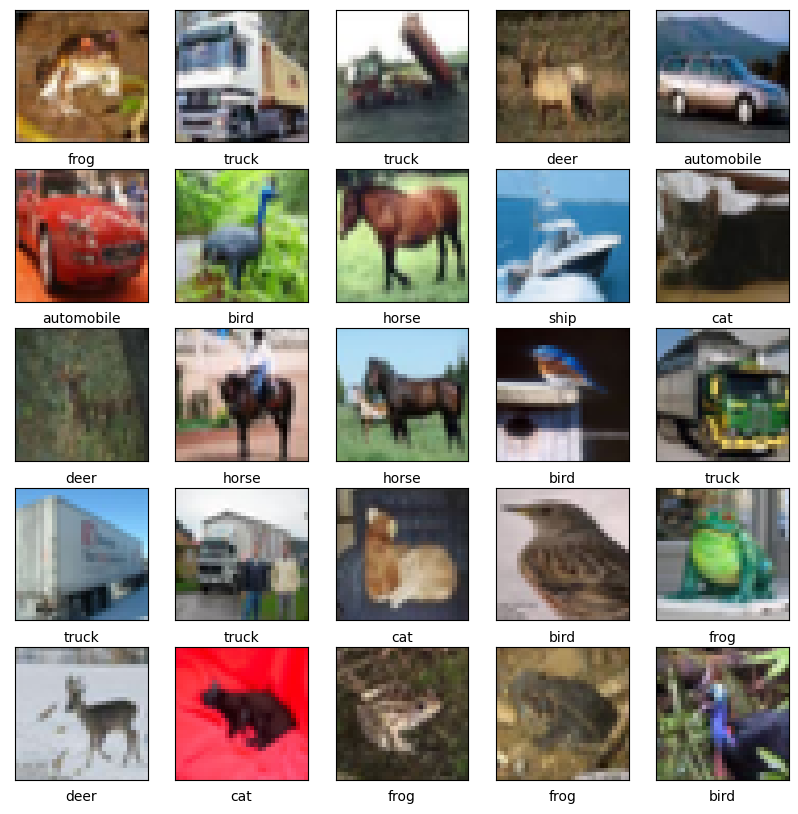

In [4]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

### 합성곱 층 만들기

아래 6줄의 코드에서 [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)와 [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) 층을 쌓는 일반적인 패턴으로 합성곱 층을 정의합니다.

입력으로 CNN은 배치 크기를 무시하고 형상(image_height, image_width, color_channels)의 텐서를 사용합니다. 이러한 차원을 처음 접하는 경우 color_channels는 (R,G,B)를 나타냅니다. 이 예에서는 CIFAR 이미지 형식인 형상(32, 32, 3)의 입력을 처리하도록 CNN을 구성합니다. `input_shape` 인수를 첫 번째 레이어에 전달하여 이를 수행할 수 있습니다.


In [5]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

지금까지 모델의 아키텍처를 표시해 보겠습니다.

In [6]:
model.summary()

Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 conv2d (Conv2D)             (None, 30, 30, 32)        896       


 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         


 )                                                               


 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     


 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         


 2D)                                                             


 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     


Total params: 56,320


Trainable params: 56,320


Non-trainable params: 0


_________________________________________________________________


위에서 Conv2D와 MaxPooling2D 층의 출력은 (높이, 너비, 채널) 크기의 3D 텐서입니다. 높이와 너비 차원은 네트워크가 깊어질수록 감소하는 경향을 가집니다. Conv2D 층에서 출력 채널의 수는 첫 번째 매개변수에 의해 결정됩니다(예를 들면, 32 또는 64). 일반적으로 높이와 너비가 줄어듦에 따라 (계산 비용 측면에서) Conv2D 층의 출력 채널을 늘릴 수 있습니다.

### 마지막에 Dense 층 추가하기

모델을 완성하려면 마지막 합성곱 층의 출력 텐서(크기 (4, 4, 64))를 하나 이상의 Dense 층에 주입하여 분류를 수행합니다. Dense 층은 벡터(1D)를 입력으로 받는데 현재 출력은 3D 텐서입니다. 먼저 3D 출력을 1D로 펼치겠습니다. 그다음 하나 이상의 Dense 층을 그 위에 추가하겠습니다. MNIST 데이터는 10개의 클래스가 있으므로 마지막에 Dense 층에 10개의 출력과 소프트맥스 활성화 함수를 사용합니다.

In [7]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

다음은 모델의 전체 아키텍처입니다.

In [8]:
model.summary()

Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 conv2d (Conv2D)             (None, 30, 30, 32)        896       


 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         


 )                                                               


 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     


 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         


 2D)                                                             


 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     


 flatten (Flatten)           (None, 1024)              0         


 dense (Dense)               (None, 64)                65600     


 dense_1 (Dense)             (None, 10)                650       


Total params: 122,570


Trainable params: 122,570


Non-trainable params: 0


_________________________________________________________________


네트워크 요약은 (4, 4, 64) 출력이 두 개의 Dense 레이어를 거치기 전에 (1024) 형상의 벡터로 평면화되었음을 보여줍니다.

### 모델 컴파일과 훈련하기

In [9]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10



   1/1563 [..............................] - ETA: 1:33:08 - loss: 2.3045 - accuracy: 0.0938


  13/1563 [..............................] - ETA: 6s - loss: 2.3078 - accuracy: 0.1154     


  26/1563 [..............................] - ETA: 6s - loss: 2.3003 - accuracy: 0.1178


  39/1563 [..............................] - ETA: 6s - loss: 2.2826 - accuracy: 0.1298


  52/1563 [..............................] - ETA: 6s - loss: 2.2685 - accuracy: 0.1286


  65/1563 [>.............................] - ETA: 6s - loss: 2.2454 - accuracy: 0.1385


  78/1563 [>.............................] - ETA: 6s - loss: 2.2123 - accuracy: 0.1522


  91/1563 [>.............................] - ETA: 6s - loss: 2.1869 - accuracy: 0.1593


 104/1563 [>.............................] - ETA: 5s - loss: 2.1567 - accuracy: 0.1725


 117/1563 [=>............................] - ETA: 5s - loss: 2.1317 - accuracy: 0.1782


 131/1563 [=>............................] - ETA: 5s - loss: 2.1150 - accuracy: 0.1832


 144/1563 [=>............................] - ETA: 5s - loss: 2.0970 - accuracy: 0.1929


 157/1563 [==>...........................] - ETA: 5s - loss: 2.0735 - accuracy: 0.2034


 170/1563 [==>...........................] - ETA: 5s - loss: 2.0583 - accuracy: 0.2118


 183/1563 [==>...........................] - ETA: 5s - loss: 2.0413 - accuracy: 0.2205


 196/1563 [==>...........................] - ETA: 5s - loss: 2.0270 - accuracy: 0.2251


 209/1563 [===>..........................] - ETA: 5s - loss: 2.0165 - accuracy: 0.2273


 222/1563 [===>..........................] - ETA: 5s - loss: 2.0051 - accuracy: 0.2324


 235/1563 [===>..........................] - ETA: 5s - loss: 1.9878 - accuracy: 0.2399


 248/1563 [===>..........................] - ETA: 5s - loss: 1.9719 - accuracy: 0.2480


 261/1563 [====>.........................] - ETA: 5s - loss: 1.9575 - accuracy: 0.2547


 274/1563 [====>.........................] - ETA: 5s - loss: 1.9525 - accuracy: 0.2578


 287/1563 [====>.........................] - ETA: 5s - loss: 1.9459 - accuracy: 0.2608


 300/1563 [====>.........................] - ETA: 5s - loss: 1.9366 - accuracy: 0.2655


 312/1563 [====>.........................] - ETA: 5s - loss: 1.9279 - accuracy: 0.2708


 325/1563 [=====>........................] - ETA: 4s - loss: 1.9171 - accuracy: 0.2760


 338/1563 [=====>........................] - ETA: 4s - loss: 1.9080 - accuracy: 0.2793


 351/1563 [=====>........................] - ETA: 4s - loss: 1.9007 - accuracy: 0.2829


 364/1563 [=====>........................] - ETA: 4s - loss: 1.8884 - accuracy: 0.2874


 377/1563 [======>.......................] - ETA: 4s - loss: 1.8806 - accuracy: 0.2898


 390/1563 [======>.......................] - ETA: 4s - loss: 1.8706 - accuracy: 0.2953


 403/1563 [======>.......................] - ETA: 4s - loss: 1.8601 - accuracy: 0.2990


 416/1563 [======>.......................] - ETA: 4s - loss: 1.8514 - accuracy: 0.3025


 429/1563 [=======>......................] - ETA: 4s - loss: 1.8491 - accuracy: 0.3051


 442/1563 [=======>......................] - ETA: 4s - loss: 1.8414 - accuracy: 0.3080


 455/1563 [=======>......................] - ETA: 4s - loss: 1.8321 - accuracy: 0.3120


 468/1563 [=======>......................] - ETA: 4s - loss: 1.8242 - accuracy: 0.3151


 481/1563 [========>.....................] - ETA: 4s - loss: 1.8167 - accuracy: 0.3184


 494/1563 [========>.....................] - ETA: 4s - loss: 1.8103 - accuracy: 0.3209


 507/1563 [========>.....................] - ETA: 4s - loss: 1.8058 - accuracy: 0.3237


 520/1563 [========>.....................] - ETA: 4s - loss: 1.8003 - accuracy: 0.3258


 533/1563 [=========>....................] - ETA: 4s - loss: 1.7955 - accuracy: 0.3282


 546/1563 [=========>....................] - ETA: 4s - loss: 1.7882 - accuracy: 0.3309


 559/1563 [=========>....................] - ETA: 4s - loss: 1.7838 - accuracy: 0.3330


 572/1563 [=========>....................] - ETA: 3s - loss: 1.7758 - accuracy: 0.3360


 585/1563 [==========>...................] - ETA: 3s - loss: 1.7684 - accuracy: 0.3396


 598/1563 [==========>...................] - ETA: 3s - loss: 1.7631 - accuracy: 0.3421


 611/1563 [==========>...................] - ETA: 3s - loss: 1.7568 - accuracy: 0.3445


 624/1563 [==========>...................] - ETA: 3s - loss: 1.7508 - accuracy: 0.3468


 637/1563 [===========>..................] - ETA: 3s - loss: 1.7459 - accuracy: 0.3490


 650/1563 [===========>..................] - ETA: 3s - loss: 1.7399 - accuracy: 0.3517


 663/1563 [===========>..................] - ETA: 3s - loss: 1.7338 - accuracy: 0.3534


 676/1563 [===========>..................] - ETA: 3s - loss: 1.7278 - accuracy: 0.3554


 690/1563 [============>.................] - ETA: 3s - loss: 1.7207 - accuracy: 0.3583


 703/1563 [============>.................] - ETA: 3s - loss: 1.7160 - accuracy: 0.3608


 716/1563 [============>.................] - ETA: 3s - loss: 1.7116 - accuracy: 0.3625


 729/1563 [============>.................] - ETA: 3s - loss: 1.7065 - accuracy: 0.3651


 742/1563 [=============>................] - ETA: 3s - loss: 1.7017 - accuracy: 0.3673


 755/1563 [=============>................] - ETA: 3s - loss: 1.6986 - accuracy: 0.3684


 768/1563 [=============>................] - ETA: 3s - loss: 1.6951 - accuracy: 0.3696


 781/1563 [=============>................] - ETA: 3s - loss: 1.6926 - accuracy: 0.3714


 794/1563 [==============>...............] - ETA: 3s - loss: 1.6891 - accuracy: 0.3728


 807/1563 [==============>...............] - ETA: 3s - loss: 1.6851 - accuracy: 0.3744


 819/1563 [==============>...............] - ETA: 2s - loss: 1.6810 - accuracy: 0.3758


 832/1563 [==============>...............] - ETA: 2s - loss: 1.6766 - accuracy: 0.3780


 845/1563 [===============>..............] - ETA: 2s - loss: 1.6719 - accuracy: 0.3803


 858/1563 [===============>..............] - ETA: 2s - loss: 1.6683 - accuracy: 0.3816


 871/1563 [===============>..............] - ETA: 2s - loss: 1.6643 - accuracy: 0.3830


 884/1563 [===============>..............] - ETA: 2s - loss: 1.6597 - accuracy: 0.3848


 897/1563 [================>.............] - ETA: 2s - loss: 1.6556 - accuracy: 0.3863


 910/1563 [================>.............] - ETA: 2s - loss: 1.6527 - accuracy: 0.3876


 923/1563 [================>.............] - ETA: 2s - loss: 1.6495 - accuracy: 0.3890


 936/1563 [================>.............] - ETA: 2s - loss: 1.6457 - accuracy: 0.3902


 949/1563 [=================>............] - ETA: 2s - loss: 1.6422 - accuracy: 0.3922


 962/1563 [=================>............] - ETA: 2s - loss: 1.6386 - accuracy: 0.3935


 975/1563 [=================>............] - ETA: 2s - loss: 1.6351 - accuracy: 0.3951


 988/1563 [=================>............] - ETA: 2s - loss: 1.6330 - accuracy: 0.3964


1001/1563 [==================>...........] - ETA: 2s - loss: 1.6293 - accuracy: 0.3980


1014/1563 [==================>...........] - ETA: 2s - loss: 1.6268 - accuracy: 0.3990


1027/1563 [==================>...........] - ETA: 2s - loss: 1.6244 - accuracy: 0.4001


1040/1563 [==================>...........] - ETA: 2s - loss: 1.6217 - accuracy: 0.4011


1053/1563 [===================>..........] - ETA: 2s - loss: 1.6182 - accuracy: 0.4027


1066/1563 [===================>..........] - ETA: 1s - loss: 1.6149 - accuracy: 0.4039


1079/1563 [===================>..........] - ETA: 1s - loss: 1.6126 - accuracy: 0.4047


1092/1563 [===================>..........] - ETA: 1s - loss: 1.6093 - accuracy: 0.4065


1105/1563 [====================>.........] - ETA: 1s - loss: 1.6069 - accuracy: 0.4076


1118/1563 [====================>.........] - ETA: 1s - loss: 1.6039 - accuracy: 0.4085


1132/1563 [====================>.........] - ETA: 1s - loss: 1.6014 - accuracy: 0.4095


1145/1563 [====================>.........] - ETA: 1s - loss: 1.5988 - accuracy: 0.4104


1158/1563 [=====================>........] - ETA: 1s - loss: 1.5955 - accuracy: 0.4118


1172/1563 [=====================>........] - ETA: 1s - loss: 1.5923 - accuracy: 0.4132


1185/1563 [=====================>........] - ETA: 1s - loss: 1.5906 - accuracy: 0.4140


1198/1563 [=====================>........] - ETA: 1s - loss: 1.5870 - accuracy: 0.4156


1211/1563 [======================>.......] - ETA: 1s - loss: 1.5847 - accuracy: 0.4167


1224/1563 [======================>.......] - ETA: 1s - loss: 1.5824 - accuracy: 0.4177


1237/1563 [======================>.......] - ETA: 1s - loss: 1.5805 - accuracy: 0.4186


1250/1563 [======================>.......] - ETA: 1s - loss: 1.5769 - accuracy: 0.4201


1263/1563 [=======================>......] - ETA: 1s - loss: 1.5741 - accuracy: 0.4213


1276/1563 [=======================>......] - ETA: 1s - loss: 1.5711 - accuracy: 0.4222


1289/1563 [=======================>......] - ETA: 1s - loss: 1.5692 - accuracy: 0.4232


1302/1563 [=======================>......] - ETA: 1s - loss: 1.5660 - accuracy: 0.4246


1315/1563 [========================>.....] - ETA: 0s - loss: 1.5631 - accuracy: 0.4255


1328/1563 [========================>.....] - ETA: 0s - loss: 1.5602 - accuracy: 0.4267


1341/1563 [========================>.....] - ETA: 0s - loss: 1.5579 - accuracy: 0.4275


1353/1563 [========================>.....] - ETA: 0s - loss: 1.5559 - accuracy: 0.4285


1366/1563 [=========================>....] - ETA: 0s - loss: 1.5526 - accuracy: 0.4297


1379/1563 [=========================>....] - ETA: 0s - loss: 1.5505 - accuracy: 0.4306


1392/1563 [=========================>....] - ETA: 0s - loss: 1.5491 - accuracy: 0.4312


1405/1563 [=========================>....] - ETA: 0s - loss: 1.5461 - accuracy: 0.4323


1418/1563 [==========================>...] - ETA: 0s - loss: 1.5447 - accuracy: 0.4333


1431/1563 [==========================>...] - ETA: 0s - loss: 1.5421 - accuracy: 0.4342


1445/1563 [==========================>...] - ETA: 0s - loss: 1.5398 - accuracy: 0.4352


1458/1563 [==========================>...] - ETA: 0s - loss: 1.5376 - accuracy: 0.4361


1471/1563 [===========================>..] - ETA: 0s - loss: 1.5357 - accuracy: 0.4369


1484/1563 [===========================>..] - ETA: 0s - loss: 1.5332 - accuracy: 0.4378


1497/1563 [===========================>..] - ETA: 0s - loss: 1.5311 - accuracy: 0.4387


1510/1563 [===========================>..] - ETA: 0s - loss: 1.5290 - accuracy: 0.4397


1523/1563 [============================>.] - ETA: 0s - loss: 1.5266 - accuracy: 0.4408


1536/1563 [============================>.] - ETA: 0s - loss: 1.5241 - accuracy: 0.4420


1549/1563 [============================>.] - ETA: 0s - loss: 1.5209 - accuracy: 0.4432


1562/1563 [============================>.] - ETA: 0s - loss: 1.5189 - accuracy: 0.4442


1563/1563 [==============================] - 11s 5ms/step - loss: 1.5189 - accuracy: 0.4442 - val_loss: 1.2819 - val_accuracy: 0.5381


Epoch 2/10



   1/1563 [..............................] - ETA: 8s - loss: 1.2852 - accuracy: 0.5938


  14/1563 [..............................] - ETA: 6s - loss: 1.3335 - accuracy: 0.5446


  27/1563 [..............................] - ETA: 6s - loss: 1.2663 - accuracy: 0.5544


  40/1563 [..............................] - ETA: 5s - loss: 1.2594 - accuracy: 0.5625


  53/1563 [>.............................] - ETA: 5s - loss: 1.2298 - accuracy: 0.5690


  66/1563 [>.............................] - ETA: 5s - loss: 1.2302 - accuracy: 0.5620


  79/1563 [>.............................] - ETA: 5s - loss: 1.2376 - accuracy: 0.5637


  93/1563 [>.............................] - ETA: 5s - loss: 1.2383 - accuracy: 0.5642


 107/1563 [=>............................] - ETA: 5s - loss: 1.2320 - accuracy: 0.5663


 120/1563 [=>............................] - ETA: 5s - loss: 1.2231 - accuracy: 0.5690


 133/1563 [=>............................] - ETA: 5s - loss: 1.2244 - accuracy: 0.5684


 146/1563 [=>............................] - ETA: 5s - loss: 1.2171 - accuracy: 0.5711


 159/1563 [==>...........................] - ETA: 5s - loss: 1.2153 - accuracy: 0.5708


 172/1563 [==>...........................] - ETA: 5s - loss: 1.2106 - accuracy: 0.5718


 185/1563 [==>...........................] - ETA: 5s - loss: 1.2152 - accuracy: 0.5688


 198/1563 [==>...........................] - ETA: 5s - loss: 1.2143 - accuracy: 0.5694


 211/1563 [===>..........................] - ETA: 5s - loss: 1.2086 - accuracy: 0.5714


 224/1563 [===>..........................] - ETA: 5s - loss: 1.2094 - accuracy: 0.5702


 237/1563 [===>..........................] - ETA: 5s - loss: 1.2139 - accuracy: 0.5694


 250/1563 [===>..........................] - ETA: 5s - loss: 1.2195 - accuracy: 0.5677


 263/1563 [====>.........................] - ETA: 5s - loss: 1.2134 - accuracy: 0.5719


 277/1563 [====>.........................] - ETA: 5s - loss: 1.2140 - accuracy: 0.5710


 290/1563 [====>.........................] - ETA: 4s - loss: 1.2175 - accuracy: 0.5703


 303/1563 [====>.........................] - ETA: 4s - loss: 1.2159 - accuracy: 0.5712


 316/1563 [=====>........................] - ETA: 4s - loss: 1.2154 - accuracy: 0.5710


 329/1563 [=====>........................] - ETA: 4s - loss: 1.2140 - accuracy: 0.5708


 342/1563 [=====>........................] - ETA: 4s - loss: 1.2147 - accuracy: 0.5699


 355/1563 [=====>........................] - ETA: 4s - loss: 1.2155 - accuracy: 0.5700


 369/1563 [======>.......................] - ETA: 4s - loss: 1.2152 - accuracy: 0.5690


 383/1563 [======>.......................] - ETA: 4s - loss: 1.2105 - accuracy: 0.5707


 396/1563 [======>.......................] - ETA: 4s - loss: 1.2113 - accuracy: 0.5709


 410/1563 [======>.......................] - ETA: 4s - loss: 1.2116 - accuracy: 0.5714


 423/1563 [=======>......................] - ETA: 4s - loss: 1.2095 - accuracy: 0.5717


 436/1563 [=======>......................] - ETA: 4s - loss: 1.2104 - accuracy: 0.5707


 449/1563 [=======>......................] - ETA: 4s - loss: 1.2091 - accuracy: 0.5718


 462/1563 [=======>......................] - ETA: 4s - loss: 1.2066 - accuracy: 0.5725


 475/1563 [========>.....................] - ETA: 4s - loss: 1.2055 - accuracy: 0.5733


 488/1563 [========>.....................] - ETA: 4s - loss: 1.2029 - accuracy: 0.5743


 502/1563 [========>.....................] - ETA: 4s - loss: 1.2033 - accuracy: 0.5746


 515/1563 [========>.....................] - ETA: 4s - loss: 1.2013 - accuracy: 0.5752


 528/1563 [=========>....................] - ETA: 4s - loss: 1.1985 - accuracy: 0.5764


 541/1563 [=========>....................] - ETA: 3s - loss: 1.1976 - accuracy: 0.5760


 554/1563 [=========>....................] - ETA: 3s - loss: 1.1967 - accuracy: 0.5760


 567/1563 [=========>....................] - ETA: 3s - loss: 1.1968 - accuracy: 0.5764


 580/1563 [==========>...................] - ETA: 3s - loss: 1.1963 - accuracy: 0.5767


 593/1563 [==========>...................] - ETA: 3s - loss: 1.1980 - accuracy: 0.5764


 606/1563 [==========>...................] - ETA: 3s - loss: 1.1993 - accuracy: 0.5762


 619/1563 [==========>...................] - ETA: 3s - loss: 1.1984 - accuracy: 0.5763


 633/1563 [===========>..................] - ETA: 3s - loss: 1.1980 - accuracy: 0.5760


 646/1563 [===========>..................] - ETA: 3s - loss: 1.1972 - accuracy: 0.5765


 659/1563 [===========>..................] - ETA: 3s - loss: 1.1959 - accuracy: 0.5767


 672/1563 [===========>..................] - ETA: 3s - loss: 1.1952 - accuracy: 0.5765


 686/1563 [============>.................] - ETA: 3s - loss: 1.1955 - accuracy: 0.5768


 700/1563 [============>.................] - ETA: 3s - loss: 1.1952 - accuracy: 0.5768


 713/1563 [============>.................] - ETA: 3s - loss: 1.1935 - accuracy: 0.5777


 727/1563 [============>.................] - ETA: 3s - loss: 1.1934 - accuracy: 0.5775


 741/1563 [=============>................] - ETA: 3s - loss: 1.1939 - accuracy: 0.5774


 754/1563 [=============>................] - ETA: 3s - loss: 1.1926 - accuracy: 0.5779


 767/1563 [=============>................] - ETA: 3s - loss: 1.1930 - accuracy: 0.5777


 780/1563 [=============>................] - ETA: 3s - loss: 1.1938 - accuracy: 0.5776


 793/1563 [==============>...............] - ETA: 3s - loss: 1.1923 - accuracy: 0.5785


 806/1563 [==============>...............] - ETA: 2s - loss: 1.1926 - accuracy: 0.5789


 819/1563 [==============>...............] - ETA: 2s - loss: 1.1922 - accuracy: 0.5789


 832/1563 [==============>...............] - ETA: 2s - loss: 1.1897 - accuracy: 0.5798


 845/1563 [===============>..............] - ETA: 2s - loss: 1.1898 - accuracy: 0.5796


 858/1563 [===============>..............] - ETA: 2s - loss: 1.1892 - accuracy: 0.5795


 872/1563 [===============>..............] - ETA: 2s - loss: 1.1861 - accuracy: 0.5808


 886/1563 [================>.............] - ETA: 2s - loss: 1.1854 - accuracy: 0.5808


 899/1563 [================>.............] - ETA: 2s - loss: 1.1856 - accuracy: 0.5808


 913/1563 [================>.............] - ETA: 2s - loss: 1.1854 - accuracy: 0.5808


 927/1563 [================>.............] - ETA: 2s - loss: 1.1842 - accuracy: 0.5814


 940/1563 [=================>............] - ETA: 2s - loss: 1.1838 - accuracy: 0.5817


 953/1563 [=================>............] - ETA: 2s - loss: 1.1838 - accuracy: 0.5819


 966/1563 [=================>............] - ETA: 2s - loss: 1.1821 - accuracy: 0.5826


 979/1563 [=================>............] - ETA: 2s - loss: 1.1813 - accuracy: 0.5828


 992/1563 [==================>...........] - ETA: 2s - loss: 1.1811 - accuracy: 0.5826


1005/1563 [==================>...........] - ETA: 2s - loss: 1.1808 - accuracy: 0.5828


1018/1563 [==================>...........] - ETA: 2s - loss: 1.1800 - accuracy: 0.5830


1031/1563 [==================>...........] - ETA: 2s - loss: 1.1798 - accuracy: 0.5829


1045/1563 [===================>..........] - ETA: 2s - loss: 1.1783 - accuracy: 0.5833


1058/1563 [===================>..........] - ETA: 1s - loss: 1.1757 - accuracy: 0.5841


1071/1563 [===================>..........] - ETA: 1s - loss: 1.1746 - accuracy: 0.5844


1084/1563 [===================>..........] - ETA: 1s - loss: 1.1738 - accuracy: 0.5844


1098/1563 [====================>.........] - ETA: 1s - loss: 1.1727 - accuracy: 0.5848


1111/1563 [====================>.........] - ETA: 1s - loss: 1.1708 - accuracy: 0.5855


1124/1563 [====================>.........] - ETA: 1s - loss: 1.1706 - accuracy: 0.5855


1138/1563 [====================>.........] - ETA: 1s - loss: 1.1697 - accuracy: 0.5858


1151/1563 [=====================>........] - ETA: 1s - loss: 1.1684 - accuracy: 0.5860


1164/1563 [=====================>........] - ETA: 1s - loss: 1.1671 - accuracy: 0.5864


1177/1563 [=====================>........] - ETA: 1s - loss: 1.1654 - accuracy: 0.5869


1190/1563 [=====================>........] - ETA: 1s - loss: 1.1654 - accuracy: 0.5869


1203/1563 [======================>.......] - ETA: 1s - loss: 1.1646 - accuracy: 0.5873


1216/1563 [======================>.......] - ETA: 1s - loss: 1.1643 - accuracy: 0.5874


1230/1563 [======================>.......] - ETA: 1s - loss: 1.1634 - accuracy: 0.5877


1244/1563 [======================>.......] - ETA: 1s - loss: 1.1617 - accuracy: 0.5883


1257/1563 [=======================>......] - ETA: 1s - loss: 1.1617 - accuracy: 0.5883


1270/1563 [=======================>......] - ETA: 1s - loss: 1.1613 - accuracy: 0.5883


1283/1563 [=======================>......] - ETA: 1s - loss: 1.1608 - accuracy: 0.5885


1296/1563 [=======================>......] - ETA: 1s - loss: 1.1602 - accuracy: 0.5885


1309/1563 [========================>.....] - ETA: 0s - loss: 1.1590 - accuracy: 0.5891


1322/1563 [========================>.....] - ETA: 0s - loss: 1.1582 - accuracy: 0.5895


1335/1563 [========================>.....] - ETA: 0s - loss: 1.1577 - accuracy: 0.5899


1348/1563 [========================>.....] - ETA: 0s - loss: 1.1571 - accuracy: 0.5901


1361/1563 [=========================>....] - ETA: 0s - loss: 1.1569 - accuracy: 0.5902


1375/1563 [=========================>....] - ETA: 0s - loss: 1.1562 - accuracy: 0.5907


1388/1563 [=========================>....] - ETA: 0s - loss: 1.1556 - accuracy: 0.5910


1401/1563 [=========================>....] - ETA: 0s - loss: 1.1550 - accuracy: 0.5913


1414/1563 [==========================>...] - ETA: 0s - loss: 1.1544 - accuracy: 0.5918


1427/1563 [==========================>...] - ETA: 0s - loss: 1.1537 - accuracy: 0.5922


1440/1563 [==========================>...] - ETA: 0s - loss: 1.1524 - accuracy: 0.5926


1453/1563 [==========================>...] - ETA: 0s - loss: 1.1519 - accuracy: 0.5930


1466/1563 [===========================>..] - ETA: 0s - loss: 1.1507 - accuracy: 0.5936


1479/1563 [===========================>..] - ETA: 0s - loss: 1.1503 - accuracy: 0.5937


1493/1563 [===========================>..] - ETA: 0s - loss: 1.1494 - accuracy: 0.5937


1506/1563 [===========================>..] - ETA: 0s - loss: 1.1490 - accuracy: 0.5939


1519/1563 [============================>.] - ETA: 0s - loss: 1.1485 - accuracy: 0.5939


1532/1563 [============================>.] - ETA: 0s - loss: 1.1472 - accuracy: 0.5941


1545/1563 [============================>.] - ETA: 0s - loss: 1.1470 - accuracy: 0.5942


1558/1563 [============================>.] - ETA: 0s - loss: 1.1466 - accuracy: 0.5943


1563/1563 [==============================] - 7s 4ms/step - loss: 1.1463 - accuracy: 0.5945 - val_loss: 1.0690 - val_accuracy: 0.6251


Epoch 3/10



   1/1563 [..............................] - ETA: 8s - loss: 1.1098 - accuracy: 0.5938


  14/1563 [..............................] - ETA: 6s - loss: 0.9757 - accuracy: 0.6429


  27/1563 [..............................] - ETA: 6s - loss: 0.9986 - accuracy: 0.6354


  40/1563 [..............................] - ETA: 6s - loss: 0.9974 - accuracy: 0.6398


  53/1563 [>.............................] - ETA: 5s - loss: 0.9916 - accuracy: 0.6445


  66/1563 [>.............................] - ETA: 5s - loss: 1.0083 - accuracy: 0.6397


  79/1563 [>.............................] - ETA: 5s - loss: 1.0226 - accuracy: 0.6353


  92/1563 [>.............................] - ETA: 5s - loss: 1.0163 - accuracy: 0.6410


 105/1563 [=>............................] - ETA: 5s - loss: 1.0221 - accuracy: 0.6399


 118/1563 [=>............................] - ETA: 5s - loss: 1.0328 - accuracy: 0.6364


 131/1563 [=>............................] - ETA: 5s - loss: 1.0368 - accuracy: 0.6338


 144/1563 [=>............................] - ETA: 5s - loss: 1.0359 - accuracy: 0.6348


 157/1563 [==>...........................] - ETA: 5s - loss: 1.0357 - accuracy: 0.6346


 170/1563 [==>...........................] - ETA: 5s - loss: 1.0284 - accuracy: 0.6382


 183/1563 [==>...........................] - ETA: 5s - loss: 1.0292 - accuracy: 0.6385


 196/1563 [==>...........................] - ETA: 5s - loss: 1.0355 - accuracy: 0.6352


 209/1563 [===>..........................] - ETA: 5s - loss: 1.0377 - accuracy: 0.6346


 222/1563 [===>..........................] - ETA: 5s - loss: 1.0393 - accuracy: 0.6351


 235/1563 [===>..........................] - ETA: 5s - loss: 1.0401 - accuracy: 0.6339


 248/1563 [===>..........................] - ETA: 5s - loss: 1.0414 - accuracy: 0.6331


 261/1563 [====>.........................] - ETA: 5s - loss: 1.0402 - accuracy: 0.6337


 274/1563 [====>.........................] - ETA: 5s - loss: 1.0417 - accuracy: 0.6330


 287/1563 [====>.........................] - ETA: 5s - loss: 1.0426 - accuracy: 0.6313


 300/1563 [====>.........................] - ETA: 4s - loss: 1.0413 - accuracy: 0.6323


 313/1563 [=====>........................] - ETA: 4s - loss: 1.0406 - accuracy: 0.6333


 326/1563 [=====>........................] - ETA: 4s - loss: 1.0411 - accuracy: 0.6330


 339/1563 [=====>........................] - ETA: 4s - loss: 1.0397 - accuracy: 0.6341


 352/1563 [=====>........................] - ETA: 4s - loss: 1.0411 - accuracy: 0.6337


 365/1563 [======>.......................] - ETA: 4s - loss: 1.0408 - accuracy: 0.6342


 378/1563 [======>.......................] - ETA: 4s - loss: 1.0422 - accuracy: 0.6332


 391/1563 [======>.......................] - ETA: 4s - loss: 1.0421 - accuracy: 0.6331


 404/1563 [======>.......................] - ETA: 4s - loss: 1.0435 - accuracy: 0.6327


 417/1563 [=======>......................] - ETA: 4s - loss: 1.0430 - accuracy: 0.6329


 430/1563 [=======>......................] - ETA: 4s - loss: 1.0409 - accuracy: 0.6347


 443/1563 [=======>......................] - ETA: 4s - loss: 1.0404 - accuracy: 0.6352


 456/1563 [=======>......................] - ETA: 4s - loss: 1.0396 - accuracy: 0.6351


 469/1563 [========>.....................] - ETA: 4s - loss: 1.0369 - accuracy: 0.6361


 482/1563 [========>.....................] - ETA: 4s - loss: 1.0343 - accuracy: 0.6364


 495/1563 [========>.....................] - ETA: 4s - loss: 1.0322 - accuracy: 0.6373


 508/1563 [========>.....................] - ETA: 4s - loss: 1.0300 - accuracy: 0.6382


 521/1563 [=========>....................] - ETA: 4s - loss: 1.0280 - accuracy: 0.6381


 534/1563 [=========>....................] - ETA: 4s - loss: 1.0281 - accuracy: 0.6377


 547/1563 [=========>....................] - ETA: 4s - loss: 1.0280 - accuracy: 0.6381


 560/1563 [=========>....................] - ETA: 3s - loss: 1.0255 - accuracy: 0.6391


 573/1563 [=========>....................] - ETA: 3s - loss: 1.0232 - accuracy: 0.6398


 586/1563 [==========>...................] - ETA: 3s - loss: 1.0238 - accuracy: 0.6397


 599/1563 [==========>...................] - ETA: 3s - loss: 1.0245 - accuracy: 0.6395


 612/1563 [==========>...................] - ETA: 3s - loss: 1.0253 - accuracy: 0.6398


 625/1563 [==========>...................] - ETA: 3s - loss: 1.0241 - accuracy: 0.6402


 637/1563 [===========>..................] - ETA: 3s - loss: 1.0236 - accuracy: 0.6406


 650/1563 [===========>..................] - ETA: 3s - loss: 1.0230 - accuracy: 0.6408


 663/1563 [===========>..................] - ETA: 3s - loss: 1.0230 - accuracy: 0.6406


 676/1563 [===========>..................] - ETA: 3s - loss: 1.0230 - accuracy: 0.6405


 689/1563 [============>.................] - ETA: 3s - loss: 1.0212 - accuracy: 0.6409


 702/1563 [============>.................] - ETA: 3s - loss: 1.0199 - accuracy: 0.6411


 715/1563 [============>.................] - ETA: 3s - loss: 1.0213 - accuracy: 0.6402


 728/1563 [============>.................] - ETA: 3s - loss: 1.0204 - accuracy: 0.6408


 741/1563 [=============>................] - ETA: 3s - loss: 1.0193 - accuracy: 0.6414


 754/1563 [=============>................] - ETA: 3s - loss: 1.0180 - accuracy: 0.6417


 767/1563 [=============>................] - ETA: 3s - loss: 1.0178 - accuracy: 0.6421


 780/1563 [=============>................] - ETA: 3s - loss: 1.0175 - accuracy: 0.6422


 793/1563 [==============>...............] - ETA: 3s - loss: 1.0168 - accuracy: 0.6427


 807/1563 [==============>...............] - ETA: 2s - loss: 1.0160 - accuracy: 0.6430


 820/1563 [==============>...............] - ETA: 2s - loss: 1.0152 - accuracy: 0.6431


 833/1563 [==============>...............] - ETA: 2s - loss: 1.0150 - accuracy: 0.6431


 846/1563 [===============>..............] - ETA: 2s - loss: 1.0160 - accuracy: 0.6434


 859/1563 [===============>..............] - ETA: 2s - loss: 1.0169 - accuracy: 0.6429


 872/1563 [===============>..............] - ETA: 2s - loss: 1.0164 - accuracy: 0.6431


 885/1563 [===============>..............] - ETA: 2s - loss: 1.0161 - accuracy: 0.6433


 898/1563 [================>.............] - ETA: 2s - loss: 1.0153 - accuracy: 0.6438


 911/1563 [================>.............] - ETA: 2s - loss: 1.0149 - accuracy: 0.6437


 924/1563 [================>.............] - ETA: 2s - loss: 1.0140 - accuracy: 0.6437


 937/1563 [================>.............] - ETA: 2s - loss: 1.0133 - accuracy: 0.6442


 950/1563 [=================>............] - ETA: 2s - loss: 1.0137 - accuracy: 0.6438


 963/1563 [=================>............] - ETA: 2s - loss: 1.0122 - accuracy: 0.6439


 976/1563 [=================>............] - ETA: 2s - loss: 1.0101 - accuracy: 0.6445


 989/1563 [=================>............] - ETA: 2s - loss: 1.0101 - accuracy: 0.6447


1002/1563 [==================>...........] - ETA: 2s - loss: 1.0101 - accuracy: 0.6442


1015/1563 [==================>...........] - ETA: 2s - loss: 1.0111 - accuracy: 0.6436


1028/1563 [==================>...........] - ETA: 2s - loss: 1.0115 - accuracy: 0.6436


1042/1563 [===================>..........] - ETA: 2s - loss: 1.0112 - accuracy: 0.6435


1055/1563 [===================>..........] - ETA: 2s - loss: 1.0113 - accuracy: 0.6431


1068/1563 [===================>..........] - ETA: 1s - loss: 1.0114 - accuracy: 0.6436


1081/1563 [===================>..........] - ETA: 1s - loss: 1.0112 - accuracy: 0.6435


1094/1563 [===================>..........] - ETA: 1s - loss: 1.0110 - accuracy: 0.6434


1107/1563 [====================>.........] - ETA: 1s - loss: 1.0110 - accuracy: 0.6437


1120/1563 [====================>.........] - ETA: 1s - loss: 1.0104 - accuracy: 0.6440


1133/1563 [====================>.........] - ETA: 1s - loss: 1.0106 - accuracy: 0.6439


1146/1563 [====================>.........] - ETA: 1s - loss: 1.0109 - accuracy: 0.6438


1159/1563 [=====================>........] - ETA: 1s - loss: 1.0106 - accuracy: 0.6438


1172/1563 [=====================>........] - ETA: 1s - loss: 1.0095 - accuracy: 0.6442


1185/1563 [=====================>........] - ETA: 1s - loss: 1.0081 - accuracy: 0.6451


1198/1563 [=====================>........] - ETA: 1s - loss: 1.0077 - accuracy: 0.6452


1211/1563 [======================>.......] - ETA: 1s - loss: 1.0083 - accuracy: 0.6451


1224/1563 [======================>.......] - ETA: 1s - loss: 1.0081 - accuracy: 0.6453


1237/1563 [======================>.......] - ETA: 1s - loss: 1.0086 - accuracy: 0.6451


1250/1563 [======================>.......] - ETA: 1s - loss: 1.0084 - accuracy: 0.6449


1263/1563 [=======================>......] - ETA: 1s - loss: 1.0083 - accuracy: 0.6449


1276/1563 [=======================>......] - ETA: 1s - loss: 1.0075 - accuracy: 0.6448


1289/1563 [=======================>......] - ETA: 1s - loss: 1.0070 - accuracy: 0.6450


1302/1563 [=======================>......] - ETA: 1s - loss: 1.0057 - accuracy: 0.6456


1315/1563 [========================>.....] - ETA: 0s - loss: 1.0057 - accuracy: 0.6454


1328/1563 [========================>.....] - ETA: 0s - loss: 1.0068 - accuracy: 0.6452


1341/1563 [========================>.....] - ETA: 0s - loss: 1.0064 - accuracy: 0.6453


1354/1563 [========================>.....] - ETA: 0s - loss: 1.0067 - accuracy: 0.6452


1367/1563 [=========================>....] - ETA: 0s - loss: 1.0071 - accuracy: 0.6449


1380/1563 [=========================>....] - ETA: 0s - loss: 1.0061 - accuracy: 0.6456


1393/1563 [=========================>....] - ETA: 0s - loss: 1.0054 - accuracy: 0.6458


1406/1563 [=========================>....] - ETA: 0s - loss: 1.0047 - accuracy: 0.6460


1419/1563 [==========================>...] - ETA: 0s - loss: 1.0048 - accuracy: 0.6459


1432/1563 [==========================>...] - ETA: 0s - loss: 1.0051 - accuracy: 0.6458


1445/1563 [==========================>...] - ETA: 0s - loss: 1.0043 - accuracy: 0.6463


1457/1563 [==========================>...] - ETA: 0s - loss: 1.0044 - accuracy: 0.6464


1470/1563 [===========================>..] - ETA: 0s - loss: 1.0048 - accuracy: 0.6462


1483/1563 [===========================>..] - ETA: 0s - loss: 1.0032 - accuracy: 0.6466


1496/1563 [===========================>..] - ETA: 0s - loss: 1.0028 - accuracy: 0.6467


1509/1563 [===========================>..] - ETA: 0s - loss: 1.0031 - accuracy: 0.6466


1522/1563 [============================>.] - ETA: 0s - loss: 1.0031 - accuracy: 0.6466


1535/1563 [============================>.] - ETA: 0s - loss: 1.0018 - accuracy: 0.6472


1548/1563 [============================>.] - ETA: 0s - loss: 1.0013 - accuracy: 0.6474


1561/1563 [============================>.] - ETA: 0s - loss: 1.0010 - accuracy: 0.6477


1563/1563 [==============================] - 7s 4ms/step - loss: 1.0011 - accuracy: 0.6477 - val_loss: 0.9954 - val_accuracy: 0.6492


Epoch 4/10



   1/1563 [..............................] - ETA: 8s - loss: 0.7403 - accuracy: 0.6562


  14/1563 [..............................] - ETA: 6s - loss: 0.8293 - accuracy: 0.7076


  27/1563 [..............................] - ETA: 6s - loss: 0.8447 - accuracy: 0.7083


  40/1563 [..............................] - ETA: 6s - loss: 0.8770 - accuracy: 0.7000


  53/1563 [>.............................] - ETA: 5s - loss: 0.9003 - accuracy: 0.6963


  66/1563 [>.............................] - ETA: 5s - loss: 0.8972 - accuracy: 0.6965


  79/1563 [>.............................] - ETA: 5s - loss: 0.9139 - accuracy: 0.6883


  92/1563 [>.............................] - ETA: 5s - loss: 0.9121 - accuracy: 0.6878


 105/1563 [=>............................] - ETA: 5s - loss: 0.9047 - accuracy: 0.6887


 118/1563 [=>............................] - ETA: 5s - loss: 0.8992 - accuracy: 0.6899


 131/1563 [=>............................] - ETA: 5s - loss: 0.8963 - accuracy: 0.6916


 144/1563 [=>............................] - ETA: 5s - loss: 0.8978 - accuracy: 0.6914


 157/1563 [==>...........................] - ETA: 5s - loss: 0.8998 - accuracy: 0.6881


 170/1563 [==>...........................] - ETA: 5s - loss: 0.9062 - accuracy: 0.6858


 183/1563 [==>...........................] - ETA: 5s - loss: 0.9091 - accuracy: 0.6863


 196/1563 [==>...........................] - ETA: 5s - loss: 0.9045 - accuracy: 0.6872


 209/1563 [===>..........................] - ETA: 5s - loss: 0.9027 - accuracy: 0.6887


 222/1563 [===>..........................] - ETA: 5s - loss: 0.9005 - accuracy: 0.6881


 235/1563 [===>..........................] - ETA: 5s - loss: 0.9024 - accuracy: 0.6870


 248/1563 [===>..........................] - ETA: 5s - loss: 0.9033 - accuracy: 0.6869


 261/1563 [====>.........................] - ETA: 5s - loss: 0.9078 - accuracy: 0.6844


 274/1563 [====>.........................] - ETA: 5s - loss: 0.9081 - accuracy: 0.6846


 287/1563 [====>.........................] - ETA: 5s - loss: 0.9080 - accuracy: 0.6843


 300/1563 [====>.........................] - ETA: 5s - loss: 0.9117 - accuracy: 0.6833


 313/1563 [=====>........................] - ETA: 4s - loss: 0.9099 - accuracy: 0.6846


 326/1563 [=====>........................] - ETA: 4s - loss: 0.9083 - accuracy: 0.6860


 339/1563 [=====>........................] - ETA: 4s - loss: 0.9137 - accuracy: 0.6846


 352/1563 [=====>........................] - ETA: 4s - loss: 0.9123 - accuracy: 0.6844


 365/1563 [======>.......................] - ETA: 4s - loss: 0.9114 - accuracy: 0.6846


 378/1563 [======>.......................] - ETA: 4s - loss: 0.9079 - accuracy: 0.6858


 391/1563 [======>.......................] - ETA: 4s - loss: 0.9068 - accuracy: 0.6853


 404/1563 [======>.......................] - ETA: 4s - loss: 0.9064 - accuracy: 0.6857


 417/1563 [=======>......................] - ETA: 4s - loss: 0.9063 - accuracy: 0.6851


 430/1563 [=======>......................] - ETA: 4s - loss: 0.9065 - accuracy: 0.6842


 443/1563 [=======>......................] - ETA: 4s - loss: 0.9075 - accuracy: 0.6835


 456/1563 [=======>......................] - ETA: 4s - loss: 0.9063 - accuracy: 0.6833


 469/1563 [========>.....................] - ETA: 4s - loss: 0.9053 - accuracy: 0.6840


 482/1563 [========>.....................] - ETA: 4s - loss: 0.9065 - accuracy: 0.6838


 495/1563 [========>.....................] - ETA: 4s - loss: 0.9080 - accuracy: 0.6831


 508/1563 [========>.....................] - ETA: 4s - loss: 0.9091 - accuracy: 0.6831


 521/1563 [=========>....................] - ETA: 4s - loss: 0.9109 - accuracy: 0.6820


 534/1563 [=========>....................] - ETA: 4s - loss: 0.9103 - accuracy: 0.6821


 547/1563 [=========>....................] - ETA: 4s - loss: 0.9113 - accuracy: 0.6811


 560/1563 [=========>....................] - ETA: 4s - loss: 0.9092 - accuracy: 0.6820


 573/1563 [=========>....................] - ETA: 3s - loss: 0.9087 - accuracy: 0.6824


 586/1563 [==========>...................] - ETA: 3s - loss: 0.9083 - accuracy: 0.6826


 599/1563 [==========>...................] - ETA: 3s - loss: 0.9091 - accuracy: 0.6829


 612/1563 [==========>...................] - ETA: 3s - loss: 0.9083 - accuracy: 0.6831


 625/1563 [==========>...................] - ETA: 3s - loss: 0.9089 - accuracy: 0.6829


 638/1563 [===========>..................] - ETA: 3s - loss: 0.9090 - accuracy: 0.6827


 651/1563 [===========>..................] - ETA: 3s - loss: 0.9079 - accuracy: 0.6830


 664/1563 [===========>..................] - ETA: 3s - loss: 0.9081 - accuracy: 0.6829


 677/1563 [===========>..................] - ETA: 3s - loss: 0.9079 - accuracy: 0.6832


 690/1563 [============>.................] - ETA: 3s - loss: 0.9061 - accuracy: 0.6838


 703/1563 [============>.................] - ETA: 3s - loss: 0.9058 - accuracy: 0.6840


 716/1563 [============>.................] - ETA: 3s - loss: 0.9064 - accuracy: 0.6837


 729/1563 [============>.................] - ETA: 3s - loss: 0.9081 - accuracy: 0.6833


 742/1563 [=============>................] - ETA: 3s - loss: 0.9076 - accuracy: 0.6833


 755/1563 [=============>................] - ETA: 3s - loss: 0.9074 - accuracy: 0.6834


 768/1563 [=============>................] - ETA: 3s - loss: 0.9078 - accuracy: 0.6838


 781/1563 [=============>................] - ETA: 3s - loss: 0.9073 - accuracy: 0.6839


 793/1563 [==============>...............] - ETA: 3s - loss: 0.9063 - accuracy: 0.6844


 806/1563 [==============>...............] - ETA: 3s - loss: 0.9056 - accuracy: 0.6848


 819/1563 [==============>...............] - ETA: 2s - loss: 0.9053 - accuracy: 0.6849


 832/1563 [==============>...............] - ETA: 2s - loss: 0.9060 - accuracy: 0.6842


 845/1563 [===============>..............] - ETA: 2s - loss: 0.9057 - accuracy: 0.6847


 858/1563 [===============>..............] - ETA: 2s - loss: 0.9059 - accuracy: 0.6848


 871/1563 [===============>..............] - ETA: 2s - loss: 0.9071 - accuracy: 0.6845


 884/1563 [===============>..............] - ETA: 2s - loss: 0.9069 - accuracy: 0.6843


 897/1563 [================>.............] - ETA: 2s - loss: 0.9058 - accuracy: 0.6846


 910/1563 [================>.............] - ETA: 2s - loss: 0.9046 - accuracy: 0.6852


 923/1563 [================>.............] - ETA: 2s - loss: 0.9045 - accuracy: 0.6852


 936/1563 [================>.............] - ETA: 2s - loss: 0.9044 - accuracy: 0.6852


 949/1563 [=================>............] - ETA: 2s - loss: 0.9052 - accuracy: 0.6849


 962/1563 [=================>............] - ETA: 2s - loss: 0.9045 - accuracy: 0.6848


 975/1563 [=================>............] - ETA: 2s - loss: 0.9047 - accuracy: 0.6846


 988/1563 [=================>............] - ETA: 2s - loss: 0.9034 - accuracy: 0.6853


1001/1563 [==================>...........] - ETA: 2s - loss: 0.9030 - accuracy: 0.6853


1014/1563 [==================>...........] - ETA: 2s - loss: 0.9022 - accuracy: 0.6856


1027/1563 [==================>...........] - ETA: 2s - loss: 0.9022 - accuracy: 0.6857


1040/1563 [==================>...........] - ETA: 2s - loss: 0.9021 - accuracy: 0.6859


1053/1563 [===================>..........] - ETA: 2s - loss: 0.9021 - accuracy: 0.6859


1066/1563 [===================>..........] - ETA: 1s - loss: 0.9021 - accuracy: 0.6860


1079/1563 [===================>..........] - ETA: 1s - loss: 0.9022 - accuracy: 0.6858


1092/1563 [===================>..........] - ETA: 1s - loss: 0.9011 - accuracy: 0.6859


1105/1563 [====================>.........] - ETA: 1s - loss: 0.9012 - accuracy: 0.6861


1118/1563 [====================>.........] - ETA: 1s - loss: 0.9018 - accuracy: 0.6860


1131/1563 [====================>.........] - ETA: 1s - loss: 0.9021 - accuracy: 0.6859


1144/1563 [====================>.........] - ETA: 1s - loss: 0.9023 - accuracy: 0.6858


1157/1563 [=====================>........] - ETA: 1s - loss: 0.9031 - accuracy: 0.6858


1171/1563 [=====================>........] - ETA: 1s - loss: 0.9038 - accuracy: 0.6853


1184/1563 [=====================>........] - ETA: 1s - loss: 0.9047 - accuracy: 0.6850


1197/1563 [=====================>........] - ETA: 1s - loss: 0.9044 - accuracy: 0.6852


1210/1563 [======================>.......] - ETA: 1s - loss: 0.9037 - accuracy: 0.6856


1223/1563 [======================>.......] - ETA: 1s - loss: 0.9034 - accuracy: 0.6855


1236/1563 [======================>.......] - ETA: 1s - loss: 0.9024 - accuracy: 0.6858


1249/1563 [======================>.......] - ETA: 1s - loss: 0.9021 - accuracy: 0.6859


1262/1563 [=======================>......] - ETA: 1s - loss: 0.9024 - accuracy: 0.6857


1274/1563 [=======================>......] - ETA: 1s - loss: 0.9020 - accuracy: 0.6861


1287/1563 [=======================>......] - ETA: 1s - loss: 0.9024 - accuracy: 0.6859


1300/1563 [=======================>......] - ETA: 1s - loss: 0.9034 - accuracy: 0.6855


1313/1563 [========================>.....] - ETA: 1s - loss: 0.9026 - accuracy: 0.6859


1326/1563 [========================>.....] - ETA: 0s - loss: 0.9022 - accuracy: 0.6860


1339/1563 [========================>.....] - ETA: 0s - loss: 0.9016 - accuracy: 0.6862


1352/1563 [========================>.....] - ETA: 0s - loss: 0.9015 - accuracy: 0.6860


1365/1563 [=========================>....] - ETA: 0s - loss: 0.9019 - accuracy: 0.6856


1378/1563 [=========================>....] - ETA: 0s - loss: 0.9023 - accuracy: 0.6852


1391/1563 [=========================>....] - ETA: 0s - loss: 0.9027 - accuracy: 0.6852


1404/1563 [=========================>....] - ETA: 0s - loss: 0.9023 - accuracy: 0.6855


1417/1563 [==========================>...] - ETA: 0s - loss: 0.9029 - accuracy: 0.6852


1430/1563 [==========================>...] - ETA: 0s - loss: 0.9028 - accuracy: 0.6853


1443/1563 [==========================>...] - ETA: 0s - loss: 0.9029 - accuracy: 0.6852


1456/1563 [==========================>...] - ETA: 0s - loss: 0.9024 - accuracy: 0.6853


1469/1563 [===========================>..] - ETA: 0s - loss: 0.9023 - accuracy: 0.6853


1482/1563 [===========================>..] - ETA: 0s - loss: 0.9015 - accuracy: 0.6856


1495/1563 [===========================>..] - ETA: 0s - loss: 0.9014 - accuracy: 0.6856


1508/1563 [===========================>..] - ETA: 0s - loss: 0.9012 - accuracy: 0.6856


1520/1563 [============================>.] - ETA: 0s - loss: 0.9013 - accuracy: 0.6857


1533/1563 [============================>.] - ETA: 0s - loss: 0.9016 - accuracy: 0.6856


1546/1563 [============================>.] - ETA: 0s - loss: 0.9023 - accuracy: 0.6853


1559/1563 [============================>.] - ETA: 0s - loss: 0.9018 - accuracy: 0.6857


1563/1563 [==============================] - 7s 4ms/step - loss: 0.9019 - accuracy: 0.6856 - val_loss: 0.9277 - val_accuracy: 0.6760


Epoch 5/10



   1/1563 [..............................] - ETA: 8s - loss: 0.8462 - accuracy: 0.7500


  13/1563 [..............................] - ETA: 6s - loss: 0.9142 - accuracy: 0.7067


  25/1563 [..............................] - ETA: 6s - loss: 0.8801 - accuracy: 0.7063


  37/1563 [..............................] - ETA: 6s - loss: 0.8417 - accuracy: 0.7230


  50/1563 [..............................] - ETA: 6s - loss: 0.8174 - accuracy: 0.7262


  63/1563 [>.............................] - ETA: 6s - loss: 0.8310 - accuracy: 0.7192


  76/1563 [>.............................] - ETA: 6s - loss: 0.8302 - accuracy: 0.7171


  89/1563 [>.............................] - ETA: 5s - loss: 0.8335 - accuracy: 0.7096


 102/1563 [>.............................] - ETA: 5s - loss: 0.8321 - accuracy: 0.7071


 115/1563 [=>............................] - ETA: 5s - loss: 0.8325 - accuracy: 0.7073


 128/1563 [=>............................] - ETA: 5s - loss: 0.8291 - accuracy: 0.7107


 140/1563 [=>............................] - ETA: 5s - loss: 0.8239 - accuracy: 0.7114


 153/1563 [=>............................] - ETA: 5s - loss: 0.8219 - accuracy: 0.7122


 165/1563 [==>...........................] - ETA: 5s - loss: 0.8230 - accuracy: 0.7112


 178/1563 [==>...........................] - ETA: 5s - loss: 0.8179 - accuracy: 0.7124


 191/1563 [==>...........................] - ETA: 5s - loss: 0.8240 - accuracy: 0.7089


 204/1563 [==>...........................] - ETA: 5s - loss: 0.8278 - accuracy: 0.7089


 217/1563 [===>..........................] - ETA: 5s - loss: 0.8263 - accuracy: 0.7082


 230/1563 [===>..........................] - ETA: 5s - loss: 0.8199 - accuracy: 0.7120


 243/1563 [===>..........................] - ETA: 5s - loss: 0.8231 - accuracy: 0.7112


 256/1563 [===>..........................] - ETA: 5s - loss: 0.8226 - accuracy: 0.7117


 269/1563 [====>.........................] - ETA: 5s - loss: 0.8220 - accuracy: 0.7113


 282/1563 [====>.........................] - ETA: 5s - loss: 0.8248 - accuracy: 0.7109


 295/1563 [====>.........................] - ETA: 5s - loss: 0.8294 - accuracy: 0.7094


 308/1563 [====>.........................] - ETA: 5s - loss: 0.8320 - accuracy: 0.7089


 321/1563 [=====>........................] - ETA: 5s - loss: 0.8312 - accuracy: 0.7092


 334/1563 [=====>........................] - ETA: 4s - loss: 0.8311 - accuracy: 0.7091


 347/1563 [=====>........................] - ETA: 4s - loss: 0.8298 - accuracy: 0.7089


 360/1563 [=====>........................] - ETA: 4s - loss: 0.8264 - accuracy: 0.7106


 373/1563 [======>.......................] - ETA: 4s - loss: 0.8241 - accuracy: 0.7119


 386/1563 [======>.......................] - ETA: 4s - loss: 0.8222 - accuracy: 0.7126


 399/1563 [======>.......................] - ETA: 4s - loss: 0.8211 - accuracy: 0.7120


 412/1563 [======>.......................] - ETA: 4s - loss: 0.8217 - accuracy: 0.7117


 425/1563 [=======>......................] - ETA: 4s - loss: 0.8262 - accuracy: 0.7110


 438/1563 [=======>......................] - ETA: 4s - loss: 0.8301 - accuracy: 0.7098


 451/1563 [=======>......................] - ETA: 4s - loss: 0.8289 - accuracy: 0.7104


 464/1563 [=======>......................] - ETA: 4s - loss: 0.8292 - accuracy: 0.7099


 477/1563 [========>.....................] - ETA: 4s - loss: 0.8263 - accuracy: 0.7107


 490/1563 [========>.....................] - ETA: 4s - loss: 0.8270 - accuracy: 0.7105


 504/1563 [========>.....................] - ETA: 4s - loss: 0.8265 - accuracy: 0.7103


 517/1563 [========>.....................] - ETA: 4s - loss: 0.8272 - accuracy: 0.7100


 530/1563 [=========>....................] - ETA: 4s - loss: 0.8278 - accuracy: 0.7098


 544/1563 [=========>....................] - ETA: 4s - loss: 0.8256 - accuracy: 0.7108


 558/1563 [=========>....................] - ETA: 4s - loss: 0.8259 - accuracy: 0.7102


 571/1563 [=========>....................] - ETA: 3s - loss: 0.8255 - accuracy: 0.7108


 584/1563 [==========>...................] - ETA: 3s - loss: 0.8258 - accuracy: 0.7099


 597/1563 [==========>...................] - ETA: 3s - loss: 0.8267 - accuracy: 0.7095


 610/1563 [==========>...................] - ETA: 3s - loss: 0.8265 - accuracy: 0.7097


 623/1563 [==========>...................] - ETA: 3s - loss: 0.8302 - accuracy: 0.7084


 636/1563 [===========>..................] - ETA: 3s - loss: 0.8322 - accuracy: 0.7074


 649/1563 [===========>..................] - ETA: 3s - loss: 0.8337 - accuracy: 0.7068


 662/1563 [===========>..................] - ETA: 3s - loss: 0.8332 - accuracy: 0.7070


 675/1563 [===========>..................] - ETA: 3s - loss: 0.8324 - accuracy: 0.7080


 688/1563 [============>.................] - ETA: 3s - loss: 0.8321 - accuracy: 0.7078


 701/1563 [============>.................] - ETA: 3s - loss: 0.8324 - accuracy: 0.7076


 714/1563 [============>.................] - ETA: 3s - loss: 0.8326 - accuracy: 0.7078


 727/1563 [============>.................] - ETA: 3s - loss: 0.8339 - accuracy: 0.7078


 740/1563 [=============>................] - ETA: 3s - loss: 0.8349 - accuracy: 0.7076


 753/1563 [=============>................] - ETA: 3s - loss: 0.8352 - accuracy: 0.7075


 766/1563 [=============>................] - ETA: 3s - loss: 0.8353 - accuracy: 0.7080


 779/1563 [=============>................] - ETA: 3s - loss: 0.8370 - accuracy: 0.7074


 792/1563 [==============>...............] - ETA: 3s - loss: 0.8368 - accuracy: 0.7074


 805/1563 [==============>...............] - ETA: 3s - loss: 0.8369 - accuracy: 0.7075


 818/1563 [==============>...............] - ETA: 2s - loss: 0.8366 - accuracy: 0.7077


 831/1563 [==============>...............] - ETA: 2s - loss: 0.8359 - accuracy: 0.7079


 844/1563 [===============>..............] - ETA: 2s - loss: 0.8380 - accuracy: 0.7072


 857/1563 [===============>..............] - ETA: 2s - loss: 0.8391 - accuracy: 0.7067


 870/1563 [===============>..............] - ETA: 2s - loss: 0.8376 - accuracy: 0.7072


 883/1563 [===============>..............] - ETA: 2s - loss: 0.8379 - accuracy: 0.7070


 896/1563 [================>.............] - ETA: 2s - loss: 0.8382 - accuracy: 0.7065


 909/1563 [================>.............] - ETA: 2s - loss: 0.8373 - accuracy: 0.7069


 922/1563 [================>.............] - ETA: 2s - loss: 0.8379 - accuracy: 0.7071


 935/1563 [================>.............] - ETA: 2s - loss: 0.8363 - accuracy: 0.7076


 948/1563 [=================>............] - ETA: 2s - loss: 0.8368 - accuracy: 0.7074


 961/1563 [=================>............] - ETA: 2s - loss: 0.8357 - accuracy: 0.7081


 975/1563 [=================>............] - ETA: 2s - loss: 0.8370 - accuracy: 0.7075


 988/1563 [=================>............] - ETA: 2s - loss: 0.8361 - accuracy: 0.7078


1001/1563 [==================>...........] - ETA: 2s - loss: 0.8354 - accuracy: 0.7077


1014/1563 [==================>...........] - ETA: 2s - loss: 0.8360 - accuracy: 0.7077


1027/1563 [==================>...........] - ETA: 2s - loss: 0.8356 - accuracy: 0.7075


1040/1563 [==================>...........] - ETA: 2s - loss: 0.8356 - accuracy: 0.7076


1053/1563 [===================>..........] - ETA: 2s - loss: 0.8376 - accuracy: 0.7071


1066/1563 [===================>..........] - ETA: 1s - loss: 0.8389 - accuracy: 0.7069


1079/1563 [===================>..........] - ETA: 1s - loss: 0.8391 - accuracy: 0.7071


1092/1563 [===================>..........] - ETA: 1s - loss: 0.8389 - accuracy: 0.7074


1105/1563 [====================>.........] - ETA: 1s - loss: 0.8386 - accuracy: 0.7075


1118/1563 [====================>.........] - ETA: 1s - loss: 0.8375 - accuracy: 0.7078


1131/1563 [====================>.........] - ETA: 1s - loss: 0.8375 - accuracy: 0.7080


1144/1563 [====================>.........] - ETA: 1s - loss: 0.8377 - accuracy: 0.7079


1157/1563 [=====================>........] - ETA: 1s - loss: 0.8371 - accuracy: 0.7081


1170/1563 [=====================>........] - ETA: 1s - loss: 0.8368 - accuracy: 0.7082


1183/1563 [=====================>........] - ETA: 1s - loss: 0.8365 - accuracy: 0.7083


1196/1563 [=====================>........] - ETA: 1s - loss: 0.8361 - accuracy: 0.7084


1209/1563 [======================>.......] - ETA: 1s - loss: 0.8359 - accuracy: 0.7086


1222/1563 [======================>.......] - ETA: 1s - loss: 0.8363 - accuracy: 0.7085


1235/1563 [======================>.......] - ETA: 1s - loss: 0.8356 - accuracy: 0.7087


1248/1563 [======================>.......] - ETA: 1s - loss: 0.8355 - accuracy: 0.7089


1261/1563 [=======================>......] - ETA: 1s - loss: 0.8351 - accuracy: 0.7091


1274/1563 [=======================>......] - ETA: 1s - loss: 0.8337 - accuracy: 0.7096


1287/1563 [=======================>......] - ETA: 1s - loss: 0.8336 - accuracy: 0.7093


1300/1563 [=======================>......] - ETA: 1s - loss: 0.8332 - accuracy: 0.7095


1313/1563 [========================>.....] - ETA: 0s - loss: 0.8335 - accuracy: 0.7094


1326/1563 [========================>.....] - ETA: 0s - loss: 0.8333 - accuracy: 0.7095


1339/1563 [========================>.....] - ETA: 0s - loss: 0.8328 - accuracy: 0.7095


1352/1563 [========================>.....] - ETA: 0s - loss: 0.8317 - accuracy: 0.7100


1365/1563 [=========================>....] - ETA: 0s - loss: 0.8314 - accuracy: 0.7100


1378/1563 [=========================>....] - ETA: 0s - loss: 0.8319 - accuracy: 0.7100


1391/1563 [=========================>....] - ETA: 0s - loss: 0.8319 - accuracy: 0.7101


1404/1563 [=========================>....] - ETA: 0s - loss: 0.8326 - accuracy: 0.7099


1417/1563 [==========================>...] - ETA: 0s - loss: 0.8326 - accuracy: 0.7098


1430/1563 [==========================>...] - ETA: 0s - loss: 0.8327 - accuracy: 0.7097


1443/1563 [==========================>...] - ETA: 0s - loss: 0.8329 - accuracy: 0.7095


1456/1563 [==========================>...] - ETA: 0s - loss: 0.8329 - accuracy: 0.7094


1469/1563 [===========================>..] - ETA: 0s - loss: 0.8329 - accuracy: 0.7095


1482/1563 [===========================>..] - ETA: 0s - loss: 0.8327 - accuracy: 0.7095


1495/1563 [===========================>..] - ETA: 0s - loss: 0.8333 - accuracy: 0.7092


1509/1563 [===========================>..] - ETA: 0s - loss: 0.8334 - accuracy: 0.7091


1522/1563 [============================>.] - ETA: 0s - loss: 0.8330 - accuracy: 0.7090


1535/1563 [============================>.] - ETA: 0s - loss: 0.8331 - accuracy: 0.7090


1548/1563 [============================>.] - ETA: 0s - loss: 0.8330 - accuracy: 0.7091


1561/1563 [============================>.] - ETA: 0s - loss: 0.8331 - accuracy: 0.7090


1563/1563 [==============================] - 7s 4ms/step - loss: 0.8332 - accuracy: 0.7089 - val_loss: 0.9078 - val_accuracy: 0.6856


Epoch 6/10



   1/1563 [..............................] - ETA: 7s - loss: 1.0288 - accuracy: 0.6250


  14/1563 [..............................] - ETA: 5s - loss: 0.8501 - accuracy: 0.7143


  27/1563 [..............................] - ETA: 6s - loss: 0.8070 - accuracy: 0.7280


  40/1563 [..............................] - ETA: 6s - loss: 0.8123 - accuracy: 0.7203


  53/1563 [>.............................] - ETA: 6s - loss: 0.7760 - accuracy: 0.7353


  66/1563 [>.............................] - ETA: 5s - loss: 0.7787 - accuracy: 0.7320


  79/1563 [>.............................] - ETA: 5s - loss: 0.7672 - accuracy: 0.7330


  92/1563 [>.............................] - ETA: 5s - loss: 0.7861 - accuracy: 0.7279


 105/1563 [=>............................] - ETA: 5s - loss: 0.7826 - accuracy: 0.7262


 118/1563 [=>............................] - ETA: 5s - loss: 0.7819 - accuracy: 0.7285


 131/1563 [=>............................] - ETA: 5s - loss: 0.7820 - accuracy: 0.7276


 144/1563 [=>............................] - ETA: 5s - loss: 0.7823 - accuracy: 0.7270


 157/1563 [==>...........................] - ETA: 5s - loss: 0.7842 - accuracy: 0.7255


 170/1563 [==>...........................] - ETA: 5s - loss: 0.7804 - accuracy: 0.7263


 183/1563 [==>...........................] - ETA: 5s - loss: 0.7771 - accuracy: 0.7271


 196/1563 [==>...........................] - ETA: 5s - loss: 0.7794 - accuracy: 0.7254


 209/1563 [===>..........................] - ETA: 5s - loss: 0.7749 - accuracy: 0.7264


 222/1563 [===>..........................] - ETA: 5s - loss: 0.7794 - accuracy: 0.7241


 235/1563 [===>..........................] - ETA: 5s - loss: 0.7786 - accuracy: 0.7242


 248/1563 [===>..........................] - ETA: 5s - loss: 0.7729 - accuracy: 0.7266


 261/1563 [====>.........................] - ETA: 5s - loss: 0.7773 - accuracy: 0.7252


 274/1563 [====>.........................] - ETA: 5s - loss: 0.7764 - accuracy: 0.7263


 287/1563 [====>.........................] - ETA: 5s - loss: 0.7804 - accuracy: 0.7244


 300/1563 [====>.........................] - ETA: 5s - loss: 0.7799 - accuracy: 0.7245


 313/1563 [=====>........................] - ETA: 4s - loss: 0.7789 - accuracy: 0.7243


 326/1563 [=====>........................] - ETA: 4s - loss: 0.7815 - accuracy: 0.7242


 339/1563 [=====>........................] - ETA: 4s - loss: 0.7785 - accuracy: 0.7258


 352/1563 [=====>........................] - ETA: 4s - loss: 0.7794 - accuracy: 0.7255


 365/1563 [======>.......................] - ETA: 4s - loss: 0.7781 - accuracy: 0.7264


 378/1563 [======>.......................] - ETA: 4s - loss: 0.7762 - accuracy: 0.7278


 391/1563 [======>.......................] - ETA: 4s - loss: 0.7745 - accuracy: 0.7292


 404/1563 [======>.......................] - ETA: 4s - loss: 0.7765 - accuracy: 0.7287


 417/1563 [=======>......................] - ETA: 4s - loss: 0.7770 - accuracy: 0.7289


 430/1563 [=======>......................] - ETA: 4s - loss: 0.7774 - accuracy: 0.7281


 443/1563 [=======>......................] - ETA: 4s - loss: 0.7747 - accuracy: 0.7286


 456/1563 [=======>......................] - ETA: 4s - loss: 0.7755 - accuracy: 0.7282


 469/1563 [========>.....................] - ETA: 4s - loss: 0.7756 - accuracy: 0.7281


 482/1563 [========>.....................] - ETA: 4s - loss: 0.7743 - accuracy: 0.7278


 495/1563 [========>.....................] - ETA: 4s - loss: 0.7765 - accuracy: 0.7271


 509/1563 [========>.....................] - ETA: 4s - loss: 0.7776 - accuracy: 0.7265


 522/1563 [=========>....................] - ETA: 4s - loss: 0.7784 - accuracy: 0.7264


 535/1563 [=========>....................] - ETA: 4s - loss: 0.7781 - accuracy: 0.7265


 548/1563 [=========>....................] - ETA: 4s - loss: 0.7785 - accuracy: 0.7258


 561/1563 [=========>....................] - ETA: 3s - loss: 0.7789 - accuracy: 0.7255


 574/1563 [==========>...................] - ETA: 3s - loss: 0.7797 - accuracy: 0.7254


 587/1563 [==========>...................] - ETA: 3s - loss: 0.7799 - accuracy: 0.7254


 600/1563 [==========>...................] - ETA: 3s - loss: 0.7809 - accuracy: 0.7254


 613/1563 [==========>...................] - ETA: 3s - loss: 0.7815 - accuracy: 0.7255


 626/1563 [===========>..................] - ETA: 3s - loss: 0.7806 - accuracy: 0.7258


 639/1563 [===========>..................] - ETA: 3s - loss: 0.7799 - accuracy: 0.7258


 652/1563 [===========>..................] - ETA: 3s - loss: 0.7810 - accuracy: 0.7258


 665/1563 [===========>..................] - ETA: 3s - loss: 0.7839 - accuracy: 0.7247


 678/1563 [============>.................] - ETA: 3s - loss: 0.7842 - accuracy: 0.7243


 691/1563 [============>.................] - ETA: 3s - loss: 0.7841 - accuracy: 0.7240


 704/1563 [============>.................] - ETA: 3s - loss: 0.7836 - accuracy: 0.7245


 717/1563 [============>.................] - ETA: 3s - loss: 0.7822 - accuracy: 0.7246


 730/1563 [=============>................] - ETA: 3s - loss: 0.7812 - accuracy: 0.7251


 743/1563 [=============>................] - ETA: 3s - loss: 0.7822 - accuracy: 0.7248


 756/1563 [=============>................] - ETA: 3s - loss: 0.7836 - accuracy: 0.7238


 769/1563 [=============>................] - ETA: 3s - loss: 0.7832 - accuracy: 0.7238


 782/1563 [==============>...............] - ETA: 3s - loss: 0.7835 - accuracy: 0.7242


 795/1563 [==============>...............] - ETA: 3s - loss: 0.7835 - accuracy: 0.7238


 808/1563 [==============>...............] - ETA: 3s - loss: 0.7835 - accuracy: 0.7238


 821/1563 [==============>...............] - ETA: 2s - loss: 0.7839 - accuracy: 0.7237


 834/1563 [===============>..............] - ETA: 2s - loss: 0.7837 - accuracy: 0.7240


 847/1563 [===============>..............] - ETA: 2s - loss: 0.7837 - accuracy: 0.7239


 860/1563 [===============>..............] - ETA: 2s - loss: 0.7833 - accuracy: 0.7244


 873/1563 [===============>..............] - ETA: 2s - loss: 0.7819 - accuracy: 0.7247


 886/1563 [================>.............] - ETA: 2s - loss: 0.7820 - accuracy: 0.7246


 899/1563 [================>.............] - ETA: 2s - loss: 0.7810 - accuracy: 0.7251


 912/1563 [================>.............] - ETA: 2s - loss: 0.7817 - accuracy: 0.7249


 925/1563 [================>.............] - ETA: 2s - loss: 0.7818 - accuracy: 0.7247


 938/1563 [=================>............] - ETA: 2s - loss: 0.7820 - accuracy: 0.7247


 950/1563 [=================>............] - ETA: 2s - loss: 0.7815 - accuracy: 0.7251


 963/1563 [=================>............] - ETA: 2s - loss: 0.7831 - accuracy: 0.7245


 976/1563 [=================>............] - ETA: 2s - loss: 0.7831 - accuracy: 0.7248


 989/1563 [=================>............] - ETA: 2s - loss: 0.7821 - accuracy: 0.7250


1002/1563 [==================>...........] - ETA: 2s - loss: 0.7824 - accuracy: 0.7252


1015/1563 [==================>...........] - ETA: 2s - loss: 0.7835 - accuracy: 0.7249


1028/1563 [==================>...........] - ETA: 2s - loss: 0.7848 - accuracy: 0.7246


1041/1563 [==================>...........] - ETA: 2s - loss: 0.7854 - accuracy: 0.7245


1053/1563 [===================>..........] - ETA: 2s - loss: 0.7846 - accuracy: 0.7249


1066/1563 [===================>..........] - ETA: 1s - loss: 0.7844 - accuracy: 0.7251


1078/1563 [===================>..........] - ETA: 1s - loss: 0.7852 - accuracy: 0.7247


1091/1563 [===================>..........] - ETA: 1s - loss: 0.7857 - accuracy: 0.7244


1104/1563 [====================>.........] - ETA: 1s - loss: 0.7858 - accuracy: 0.7244


1117/1563 [====================>.........] - ETA: 1s - loss: 0.7855 - accuracy: 0.7246


1130/1563 [====================>.........] - ETA: 1s - loss: 0.7862 - accuracy: 0.7245


1143/1563 [====================>.........] - ETA: 1s - loss: 0.7863 - accuracy: 0.7242


1156/1563 [=====================>........] - ETA: 1s - loss: 0.7855 - accuracy: 0.7244


1169/1563 [=====================>........] - ETA: 1s - loss: 0.7851 - accuracy: 0.7250


1181/1563 [=====================>........] - ETA: 1s - loss: 0.7850 - accuracy: 0.7251


1194/1563 [=====================>........] - ETA: 1s - loss: 0.7851 - accuracy: 0.7253


1207/1563 [======================>.......] - ETA: 1s - loss: 0.7849 - accuracy: 0.7251


1220/1563 [======================>.......] - ETA: 1s - loss: 0.7848 - accuracy: 0.7252


1233/1563 [======================>.......] - ETA: 1s - loss: 0.7847 - accuracy: 0.7251


1246/1563 [======================>.......] - ETA: 1s - loss: 0.7847 - accuracy: 0.7251


1259/1563 [=======================>......] - ETA: 1s - loss: 0.7850 - accuracy: 0.7251


1272/1563 [=======================>......] - ETA: 1s - loss: 0.7846 - accuracy: 0.7255


1285/1563 [=======================>......] - ETA: 1s - loss: 0.7839 - accuracy: 0.7254


1298/1563 [=======================>......] - ETA: 1s - loss: 0.7837 - accuracy: 0.7256


1311/1563 [========================>.....] - ETA: 1s - loss: 0.7839 - accuracy: 0.7256


1324/1563 [========================>.....] - ETA: 0s - loss: 0.7830 - accuracy: 0.7259


1337/1563 [========================>.....] - ETA: 0s - loss: 0.7829 - accuracy: 0.7258


1350/1563 [========================>.....] - ETA: 0s - loss: 0.7826 - accuracy: 0.7258


1363/1563 [=========================>....] - ETA: 0s - loss: 0.7823 - accuracy: 0.7257


1376/1563 [=========================>....] - ETA: 0s - loss: 0.7818 - accuracy: 0.7260


1388/1563 [=========================>....] - ETA: 0s - loss: 0.7816 - accuracy: 0.7260


1401/1563 [=========================>....] - ETA: 0s - loss: 0.7810 - accuracy: 0.7263


1414/1563 [==========================>...] - ETA: 0s - loss: 0.7809 - accuracy: 0.7262


1426/1563 [==========================>...] - ETA: 0s - loss: 0.7812 - accuracy: 0.7259


1439/1563 [==========================>...] - ETA: 0s - loss: 0.7813 - accuracy: 0.7259


1452/1563 [==========================>...] - ETA: 0s - loss: 0.7811 - accuracy: 0.7261


1465/1563 [===========================>..] - ETA: 0s - loss: 0.7816 - accuracy: 0.7258


1477/1563 [===========================>..] - ETA: 0s - loss: 0.7815 - accuracy: 0.7257


1489/1563 [===========================>..] - ETA: 0s - loss: 0.7820 - accuracy: 0.7257


1502/1563 [===========================>..] - ETA: 0s - loss: 0.7819 - accuracy: 0.7257


1515/1563 [============================>.] - ETA: 0s - loss: 0.7823 - accuracy: 0.7257


1527/1563 [============================>.] - ETA: 0s - loss: 0.7825 - accuracy: 0.7256


1539/1563 [============================>.] - ETA: 0s - loss: 0.7823 - accuracy: 0.7258


1551/1563 [============================>.] - ETA: 0s - loss: 0.7819 - accuracy: 0.7258


1563/1563 [==============================] - 7s 4ms/step - loss: 0.7806 - accuracy: 0.7262 - val_loss: 0.8720 - val_accuracy: 0.7027


Epoch 7/10



   1/1563 [..............................] - ETA: 8s - loss: 0.6476 - accuracy: 0.7500


  14/1563 [..............................] - ETA: 6s - loss: 0.7276 - accuracy: 0.7522


  27/1563 [..............................] - ETA: 6s - loss: 0.6908 - accuracy: 0.7616


  40/1563 [..............................] - ETA: 6s - loss: 0.6800 - accuracy: 0.7695


  53/1563 [>.............................] - ETA: 6s - loss: 0.6677 - accuracy: 0.7730


  66/1563 [>.............................] - ETA: 6s - loss: 0.6879 - accuracy: 0.7647


  79/1563 [>.............................] - ETA: 6s - loss: 0.7043 - accuracy: 0.7587


  92/1563 [>.............................] - ETA: 6s - loss: 0.7023 - accuracy: 0.7605


 105/1563 [=>............................] - ETA: 5s - loss: 0.7029 - accuracy: 0.7610


 118/1563 [=>............................] - ETA: 5s - loss: 0.7027 - accuracy: 0.7606


 131/1563 [=>............................] - ETA: 5s - loss: 0.7094 - accuracy: 0.7586


 144/1563 [=>............................] - ETA: 5s - loss: 0.7094 - accuracy: 0.7572


 157/1563 [==>...........................] - ETA: 5s - loss: 0.7112 - accuracy: 0.7542


 170/1563 [==>...........................] - ETA: 5s - loss: 0.7105 - accuracy: 0.7548


 183/1563 [==>...........................] - ETA: 5s - loss: 0.7137 - accuracy: 0.7544


 196/1563 [==>...........................] - ETA: 5s - loss: 0.7117 - accuracy: 0.7548


 209/1563 [===>..........................] - ETA: 5s - loss: 0.7082 - accuracy: 0.7557


 221/1563 [===>..........................] - ETA: 5s - loss: 0.7064 - accuracy: 0.7557


 234/1563 [===>..........................] - ETA: 5s - loss: 0.7092 - accuracy: 0.7544


 247/1563 [===>..........................] - ETA: 5s - loss: 0.7083 - accuracy: 0.7546


 260/1563 [===>..........................] - ETA: 5s - loss: 0.7077 - accuracy: 0.7538


 273/1563 [====>.........................] - ETA: 5s - loss: 0.7066 - accuracy: 0.7522


 285/1563 [====>.........................] - ETA: 5s - loss: 0.7107 - accuracy: 0.7511


 298/1563 [====>.........................] - ETA: 5s - loss: 0.7165 - accuracy: 0.7492


 311/1563 [====>.........................] - ETA: 5s - loss: 0.7201 - accuracy: 0.7478


 324/1563 [=====>........................] - ETA: 5s - loss: 0.7174 - accuracy: 0.7489


 337/1563 [=====>........................] - ETA: 5s - loss: 0.7164 - accuracy: 0.7485


 350/1563 [=====>........................] - ETA: 4s - loss: 0.7180 - accuracy: 0.7487


 363/1563 [=====>........................] - ETA: 4s - loss: 0.7182 - accuracy: 0.7486


 375/1563 [======>.......................] - ETA: 4s - loss: 0.7175 - accuracy: 0.7485


 388/1563 [======>.......................] - ETA: 4s - loss: 0.7201 - accuracy: 0.7481


 401/1563 [======>.......................] - ETA: 4s - loss: 0.7186 - accuracy: 0.7490


 414/1563 [======>.......................] - ETA: 4s - loss: 0.7185 - accuracy: 0.7493


 427/1563 [=======>......................] - ETA: 4s - loss: 0.7202 - accuracy: 0.7493


 440/1563 [=======>......................] - ETA: 4s - loss: 0.7217 - accuracy: 0.7487


 452/1563 [=======>......................] - ETA: 4s - loss: 0.7204 - accuracy: 0.7496


 464/1563 [=======>......................] - ETA: 4s - loss: 0.7200 - accuracy: 0.7503


 477/1563 [========>.....................] - ETA: 4s - loss: 0.7213 - accuracy: 0.7502


 490/1563 [========>.....................] - ETA: 4s - loss: 0.7211 - accuracy: 0.7501


 503/1563 [========>.....................] - ETA: 4s - loss: 0.7219 - accuracy: 0.7499


 515/1563 [========>.....................] - ETA: 4s - loss: 0.7239 - accuracy: 0.7498


 527/1563 [=========>....................] - ETA: 4s - loss: 0.7232 - accuracy: 0.7500


 539/1563 [=========>....................] - ETA: 4s - loss: 0.7230 - accuracy: 0.7502


 551/1563 [=========>....................] - ETA: 4s - loss: 0.7244 - accuracy: 0.7494


 563/1563 [=========>....................] - ETA: 4s - loss: 0.7233 - accuracy: 0.7496


 576/1563 [==========>...................] - ETA: 4s - loss: 0.7254 - accuracy: 0.7492


 589/1563 [==========>...................] - ETA: 4s - loss: 0.7254 - accuracy: 0.7493


 602/1563 [==========>...................] - ETA: 3s - loss: 0.7239 - accuracy: 0.7498


 614/1563 [==========>...................] - ETA: 3s - loss: 0.7249 - accuracy: 0.7493


 626/1563 [===========>..................] - ETA: 3s - loss: 0.7263 - accuracy: 0.7489


 639/1563 [===========>..................] - ETA: 3s - loss: 0.7254 - accuracy: 0.7489


 651/1563 [===========>..................] - ETA: 3s - loss: 0.7269 - accuracy: 0.7480


 663/1563 [===========>..................] - ETA: 3s - loss: 0.7271 - accuracy: 0.7478


 676/1563 [===========>..................] - ETA: 3s - loss: 0.7288 - accuracy: 0.7471


 689/1563 [============>.................] - ETA: 3s - loss: 0.7283 - accuracy: 0.7471


 702/1563 [============>.................] - ETA: 3s - loss: 0.7274 - accuracy: 0.7472


 714/1563 [============>.................] - ETA: 3s - loss: 0.7266 - accuracy: 0.7470


 727/1563 [============>.................] - ETA: 3s - loss: 0.7263 - accuracy: 0.7470


 740/1563 [=============>................] - ETA: 3s - loss: 0.7256 - accuracy: 0.7469


 753/1563 [=============>................] - ETA: 3s - loss: 0.7254 - accuracy: 0.7468


 766/1563 [=============>................] - ETA: 3s - loss: 0.7251 - accuracy: 0.7468


 779/1563 [=============>................] - ETA: 3s - loss: 0.7254 - accuracy: 0.7465


 792/1563 [==============>...............] - ETA: 3s - loss: 0.7243 - accuracy: 0.7468


 804/1563 [==============>...............] - ETA: 3s - loss: 0.7244 - accuracy: 0.7467


 817/1563 [==============>...............] - ETA: 3s - loss: 0.7248 - accuracy: 0.7463


 830/1563 [==============>...............] - ETA: 3s - loss: 0.7263 - accuracy: 0.7459


 843/1563 [===============>..............] - ETA: 2s - loss: 0.7258 - accuracy: 0.7460


 855/1563 [===============>..............] - ETA: 2s - loss: 0.7266 - accuracy: 0.7461


 868/1563 [===============>..............] - ETA: 2s - loss: 0.7273 - accuracy: 0.7458


 881/1563 [===============>..............] - ETA: 2s - loss: 0.7281 - accuracy: 0.7454


 894/1563 [================>.............] - ETA: 2s - loss: 0.7285 - accuracy: 0.7451


 907/1563 [================>.............] - ETA: 2s - loss: 0.7280 - accuracy: 0.7456


 919/1563 [================>.............] - ETA: 2s - loss: 0.7266 - accuracy: 0.7462


 932/1563 [================>.............] - ETA: 2s - loss: 0.7259 - accuracy: 0.7465


 945/1563 [=================>............] - ETA: 2s - loss: 0.7268 - accuracy: 0.7463


 958/1563 [=================>............] - ETA: 2s - loss: 0.7277 - accuracy: 0.7456


 970/1563 [=================>............] - ETA: 2s - loss: 0.7277 - accuracy: 0.7456


 983/1563 [=================>............] - ETA: 2s - loss: 0.7283 - accuracy: 0.7455


 996/1563 [==================>...........] - ETA: 2s - loss: 0.7287 - accuracy: 0.7453


1008/1563 [==================>...........] - ETA: 2s - loss: 0.7292 - accuracy: 0.7453


1021/1563 [==================>...........] - ETA: 2s - loss: 0.7298 - accuracy: 0.7454


1034/1563 [==================>...........] - ETA: 2s - loss: 0.7290 - accuracy: 0.7456


1047/1563 [===================>..........] - ETA: 2s - loss: 0.7289 - accuracy: 0.7455


1060/1563 [===================>..........] - ETA: 2s - loss: 0.7290 - accuracy: 0.7453


1073/1563 [===================>..........] - ETA: 2s - loss: 0.7292 - accuracy: 0.7451


1086/1563 [===================>..........] - ETA: 1s - loss: 0.7290 - accuracy: 0.7454


1098/1563 [====================>.........] - ETA: 1s - loss: 0.7293 - accuracy: 0.7453


1111/1563 [====================>.........] - ETA: 1s - loss: 0.7288 - accuracy: 0.7456


1123/1563 [====================>.........] - ETA: 1s - loss: 0.7291 - accuracy: 0.7456


1136/1563 [====================>.........] - ETA: 1s - loss: 0.7297 - accuracy: 0.7454


1149/1563 [=====================>........] - ETA: 1s - loss: 0.7301 - accuracy: 0.7453


1162/1563 [=====================>........] - ETA: 1s - loss: 0.7300 - accuracy: 0.7451


1175/1563 [=====================>........] - ETA: 1s - loss: 0.7305 - accuracy: 0.7449


1187/1563 [=====================>........] - ETA: 1s - loss: 0.7313 - accuracy: 0.7446


1199/1563 [======================>.......] - ETA: 1s - loss: 0.7317 - accuracy: 0.7443


1211/1563 [======================>.......] - ETA: 1s - loss: 0.7314 - accuracy: 0.7442


1223/1563 [======================>.......] - ETA: 1s - loss: 0.7314 - accuracy: 0.7438


1236/1563 [======================>.......] - ETA: 1s - loss: 0.7317 - accuracy: 0.7437


1248/1563 [======================>.......] - ETA: 1s - loss: 0.7312 - accuracy: 0.7439


1261/1563 [=======================>......] - ETA: 1s - loss: 0.7317 - accuracy: 0.7438


1273/1563 [=======================>......] - ETA: 1s - loss: 0.7318 - accuracy: 0.7440


1285/1563 [=======================>......] - ETA: 1s - loss: 0.7330 - accuracy: 0.7436


1298/1563 [=======================>......] - ETA: 1s - loss: 0.7331 - accuracy: 0.7436


1311/1563 [========================>.....] - ETA: 1s - loss: 0.7342 - accuracy: 0.7433


1323/1563 [========================>.....] - ETA: 0s - loss: 0.7342 - accuracy: 0.7435


1335/1563 [========================>.....] - ETA: 0s - loss: 0.7335 - accuracy: 0.7437


1348/1563 [========================>.....] - ETA: 0s - loss: 0.7334 - accuracy: 0.7436


1361/1563 [=========================>....] - ETA: 0s - loss: 0.7337 - accuracy: 0.7434


1374/1563 [=========================>....] - ETA: 0s - loss: 0.7338 - accuracy: 0.7433


1386/1563 [=========================>....] - ETA: 0s - loss: 0.7332 - accuracy: 0.7436


1399/1563 [=========================>....] - ETA: 0s - loss: 0.7330 - accuracy: 0.7437


1412/1563 [==========================>...] - ETA: 0s - loss: 0.7329 - accuracy: 0.7438


1425/1563 [==========================>...] - ETA: 0s - loss: 0.7330 - accuracy: 0.7436


1437/1563 [==========================>...] - ETA: 0s - loss: 0.7323 - accuracy: 0.7437


1449/1563 [==========================>...] - ETA: 0s - loss: 0.7331 - accuracy: 0.7434


1462/1563 [===========================>..] - ETA: 0s - loss: 0.7331 - accuracy: 0.7433


1475/1563 [===========================>..] - ETA: 0s - loss: 0.7326 - accuracy: 0.7435


1488/1563 [===========================>..] - ETA: 0s - loss: 0.7325 - accuracy: 0.7437


1501/1563 [===========================>..] - ETA: 0s - loss: 0.7328 - accuracy: 0.7438


1514/1563 [============================>.] - ETA: 0s - loss: 0.7333 - accuracy: 0.7436


1527/1563 [============================>.] - ETA: 0s - loss: 0.7335 - accuracy: 0.7436


1540/1563 [============================>.] - ETA: 0s - loss: 0.7338 - accuracy: 0.7437


1553/1563 [============================>.] - ETA: 0s - loss: 0.7347 - accuracy: 0.7436


1563/1563 [==============================] - 7s 5ms/step - loss: 0.7345 - accuracy: 0.7435 - val_loss: 0.8202 - val_accuracy: 0.7193


Epoch 8/10



   1/1563 [..............................] - ETA: 8s - loss: 0.6828 - accuracy: 0.7812


  14/1563 [..............................] - ETA: 6s - loss: 0.6392 - accuracy: 0.7612


  27/1563 [..............................] - ETA: 6s - loss: 0.6190 - accuracy: 0.7685


  40/1563 [..............................] - ETA: 6s - loss: 0.6425 - accuracy: 0.7734


  53/1563 [>.............................] - ETA: 6s - loss: 0.6703 - accuracy: 0.7653


  66/1563 [>.............................] - ETA: 6s - loss: 0.6700 - accuracy: 0.7633


  79/1563 [>.............................] - ETA: 6s - loss: 0.6728 - accuracy: 0.7642


  92/1563 [>.............................] - ETA: 5s - loss: 0.6785 - accuracy: 0.7585


 105/1563 [=>............................] - ETA: 5s - loss: 0.6785 - accuracy: 0.7589


 118/1563 [=>............................] - ETA: 5s - loss: 0.6786 - accuracy: 0.7603


 131/1563 [=>............................] - ETA: 5s - loss: 0.6796 - accuracy: 0.7593


 144/1563 [=>............................] - ETA: 5s - loss: 0.6750 - accuracy: 0.7619


 157/1563 [==>...........................] - ETA: 5s - loss: 0.6786 - accuracy: 0.7619


 170/1563 [==>...........................] - ETA: 5s - loss: 0.6764 - accuracy: 0.7614


 183/1563 [==>...........................] - ETA: 5s - loss: 0.6813 - accuracy: 0.7582


 196/1563 [==>...........................] - ETA: 5s - loss: 0.6748 - accuracy: 0.7600


 209/1563 [===>..........................] - ETA: 5s - loss: 0.6779 - accuracy: 0.7593


 222/1563 [===>..........................] - ETA: 5s - loss: 0.6726 - accuracy: 0.7601


 235/1563 [===>..........................] - ETA: 5s - loss: 0.6744 - accuracy: 0.7601


 248/1563 [===>..........................] - ETA: 5s - loss: 0.6717 - accuracy: 0.7608


 261/1563 [====>.........................] - ETA: 5s - loss: 0.6700 - accuracy: 0.7620


 274/1563 [====>.........................] - ETA: 5s - loss: 0.6702 - accuracy: 0.7625


 287/1563 [====>.........................] - ETA: 5s - loss: 0.6681 - accuracy: 0.7635


 300/1563 [====>.........................] - ETA: 5s - loss: 0.6709 - accuracy: 0.7624


 313/1563 [=====>........................] - ETA: 5s - loss: 0.6697 - accuracy: 0.7625


 326/1563 [=====>........................] - ETA: 4s - loss: 0.6695 - accuracy: 0.7622


 339/1563 [=====>........................] - ETA: 4s - loss: 0.6725 - accuracy: 0.7618


 352/1563 [=====>........................] - ETA: 4s - loss: 0.6745 - accuracy: 0.7615


 365/1563 [======>.......................] - ETA: 4s - loss: 0.6749 - accuracy: 0.7613


 378/1563 [======>.......................] - ETA: 4s - loss: 0.6751 - accuracy: 0.7611


 391/1563 [======>.......................] - ETA: 4s - loss: 0.6791 - accuracy: 0.7596


 404/1563 [======>.......................] - ETA: 4s - loss: 0.6780 - accuracy: 0.7599


 417/1563 [=======>......................] - ETA: 4s - loss: 0.6793 - accuracy: 0.7593


 430/1563 [=======>......................] - ETA: 4s - loss: 0.6799 - accuracy: 0.7586


 443/1563 [=======>......................] - ETA: 4s - loss: 0.6810 - accuracy: 0.7586


 456/1563 [=======>......................] - ETA: 4s - loss: 0.6818 - accuracy: 0.7582


 469/1563 [========>.....................] - ETA: 4s - loss: 0.6842 - accuracy: 0.7578


 482/1563 [========>.....................] - ETA: 4s - loss: 0.6847 - accuracy: 0.7572


 495/1563 [========>.....................] - ETA: 4s - loss: 0.6863 - accuracy: 0.7563


 508/1563 [========>.....................] - ETA: 4s - loss: 0.6859 - accuracy: 0.7568


 521/1563 [=========>....................] - ETA: 4s - loss: 0.6860 - accuracy: 0.7571


 534/1563 [=========>....................] - ETA: 4s - loss: 0.6856 - accuracy: 0.7574


 547/1563 [=========>....................] - ETA: 4s - loss: 0.6858 - accuracy: 0.7576


 560/1563 [=========>....................] - ETA: 4s - loss: 0.6868 - accuracy: 0.7577


 573/1563 [=========>....................] - ETA: 3s - loss: 0.6863 - accuracy: 0.7583


 586/1563 [==========>...................] - ETA: 3s - loss: 0.6860 - accuracy: 0.7581


 599/1563 [==========>...................] - ETA: 3s - loss: 0.6861 - accuracy: 0.7576


 612/1563 [==========>...................] - ETA: 3s - loss: 0.6869 - accuracy: 0.7572


 625/1563 [==========>...................] - ETA: 3s - loss: 0.6876 - accuracy: 0.7571


 638/1563 [===========>..................] - ETA: 3s - loss: 0.6856 - accuracy: 0.7581


 651/1563 [===========>..................] - ETA: 3s - loss: 0.6857 - accuracy: 0.7581


 664/1563 [===========>..................] - ETA: 3s - loss: 0.6850 - accuracy: 0.7582


 677/1563 [===========>..................] - ETA: 3s - loss: 0.6852 - accuracy: 0.7582


 690/1563 [============>.................] - ETA: 3s - loss: 0.6835 - accuracy: 0.7590


 703/1563 [============>.................] - ETA: 3s - loss: 0.6835 - accuracy: 0.7588


 716/1563 [============>.................] - ETA: 3s - loss: 0.6847 - accuracy: 0.7586


 729/1563 [============>.................] - ETA: 3s - loss: 0.6851 - accuracy: 0.7585


 742/1563 [=============>................] - ETA: 3s - loss: 0.6846 - accuracy: 0.7589


 755/1563 [=============>................] - ETA: 3s - loss: 0.6882 - accuracy: 0.7577


 768/1563 [=============>................] - ETA: 3s - loss: 0.6896 - accuracy: 0.7572


 781/1563 [=============>................] - ETA: 3s - loss: 0.6890 - accuracy: 0.7576


 794/1563 [==============>...............] - ETA: 3s - loss: 0.6884 - accuracy: 0.7578


 807/1563 [==============>...............] - ETA: 3s - loss: 0.6890 - accuracy: 0.7576


 820/1563 [==============>...............] - ETA: 2s - loss: 0.6897 - accuracy: 0.7572


 833/1563 [==============>...............] - ETA: 2s - loss: 0.6898 - accuracy: 0.7569


 846/1563 [===============>..............] - ETA: 2s - loss: 0.6887 - accuracy: 0.7575


 858/1563 [===============>..............] - ETA: 2s - loss: 0.6892 - accuracy: 0.7571


 871/1563 [===============>..............] - ETA: 2s - loss: 0.6895 - accuracy: 0.7574


 884/1563 [===============>..............] - ETA: 2s - loss: 0.6883 - accuracy: 0.7580


 897/1563 [================>.............] - ETA: 2s - loss: 0.6880 - accuracy: 0.7583


 910/1563 [================>.............] - ETA: 2s - loss: 0.6880 - accuracy: 0.7585


 923/1563 [================>.............] - ETA: 2s - loss: 0.6883 - accuracy: 0.7584


 936/1563 [================>.............] - ETA: 2s - loss: 0.6882 - accuracy: 0.7585


 949/1563 [=================>............] - ETA: 2s - loss: 0.6885 - accuracy: 0.7583


 962/1563 [=================>............] - ETA: 2s - loss: 0.6883 - accuracy: 0.7585


 975/1563 [=================>............] - ETA: 2s - loss: 0.6890 - accuracy: 0.7583


 987/1563 [=================>............] - ETA: 2s - loss: 0.6887 - accuracy: 0.7585


1000/1563 [==================>...........] - ETA: 2s - loss: 0.6880 - accuracy: 0.7586


1012/1563 [==================>...........] - ETA: 2s - loss: 0.6890 - accuracy: 0.7586


1025/1563 [==================>...........] - ETA: 2s - loss: 0.6899 - accuracy: 0.7580


1038/1563 [==================>...........] - ETA: 2s - loss: 0.6892 - accuracy: 0.7581


1051/1563 [===================>..........] - ETA: 2s - loss: 0.6898 - accuracy: 0.7579


1064/1563 [===================>..........] - ETA: 2s - loss: 0.6896 - accuracy: 0.7583


1077/1563 [===================>..........] - ETA: 1s - loss: 0.6896 - accuracy: 0.7584


1090/1563 [===================>..........] - ETA: 1s - loss: 0.6893 - accuracy: 0.7585


1103/1563 [====================>.........] - ETA: 1s - loss: 0.6895 - accuracy: 0.7584


1116/1563 [====================>.........] - ETA: 1s - loss: 0.6887 - accuracy: 0.7586


1129/1563 [====================>.........] - ETA: 1s - loss: 0.6886 - accuracy: 0.7587


1142/1563 [====================>.........] - ETA: 1s - loss: 0.6881 - accuracy: 0.7588


1155/1563 [=====================>........] - ETA: 1s - loss: 0.6878 - accuracy: 0.7587


1168/1563 [=====================>........] - ETA: 1s - loss: 0.6878 - accuracy: 0.7587


1181/1563 [=====================>........] - ETA: 1s - loss: 0.6876 - accuracy: 0.7589


1194/1563 [=====================>........] - ETA: 1s - loss: 0.6883 - accuracy: 0.7586


1205/1563 [======================>.......] - ETA: 1s - loss: 0.6881 - accuracy: 0.7587


1218/1563 [======================>.......] - ETA: 1s - loss: 0.6876 - accuracy: 0.7589


1231/1563 [======================>.......] - ETA: 1s - loss: 0.6882 - accuracy: 0.7589


1244/1563 [======================>.......] - ETA: 1s - loss: 0.6876 - accuracy: 0.7591


1256/1563 [=======================>......] - ETA: 1s - loss: 0.6881 - accuracy: 0.7588


1269/1563 [=======================>......] - ETA: 1s - loss: 0.6894 - accuracy: 0.7587


1281/1563 [=======================>......] - ETA: 1s - loss: 0.6904 - accuracy: 0.7581


1294/1563 [=======================>......] - ETA: 1s - loss: 0.6900 - accuracy: 0.7583


1306/1563 [========================>.....] - ETA: 1s - loss: 0.6902 - accuracy: 0.7582


1319/1563 [========================>.....] - ETA: 0s - loss: 0.6897 - accuracy: 0.7582


1332/1563 [========================>.....] - ETA: 0s - loss: 0.6895 - accuracy: 0.7584


1344/1563 [========================>.....] - ETA: 0s - loss: 0.6890 - accuracy: 0.7586


1357/1563 [=========================>....] - ETA: 0s - loss: 0.6903 - accuracy: 0.7578


1370/1563 [=========================>....] - ETA: 0s - loss: 0.6906 - accuracy: 0.7578


1383/1563 [=========================>....] - ETA: 0s - loss: 0.6915 - accuracy: 0.7575


1396/1563 [=========================>....] - ETA: 0s - loss: 0.6921 - accuracy: 0.7571


1409/1563 [==========================>...] - ETA: 0s - loss: 0.6920 - accuracy: 0.7572


1422/1563 [==========================>...] - ETA: 0s - loss: 0.6920 - accuracy: 0.7572


1435/1563 [==========================>...] - ETA: 0s - loss: 0.6914 - accuracy: 0.7573


1448/1563 [==========================>...] - ETA: 0s - loss: 0.6919 - accuracy: 0.7572


1461/1563 [===========================>..] - ETA: 0s - loss: 0.6921 - accuracy: 0.7570


1474/1563 [===========================>..] - ETA: 0s - loss: 0.6918 - accuracy: 0.7570


1487/1563 [===========================>..] - ETA: 0s - loss: 0.6914 - accuracy: 0.7573


1500/1563 [===========================>..] - ETA: 0s - loss: 0.6914 - accuracy: 0.7571


1513/1563 [============================>.] - ETA: 0s - loss: 0.6918 - accuracy: 0.7570


1526/1563 [============================>.] - ETA: 0s - loss: 0.6923 - accuracy: 0.7569


1539/1563 [============================>.] - ETA: 0s - loss: 0.6923 - accuracy: 0.7567


1552/1563 [============================>.] - ETA: 0s - loss: 0.6928 - accuracy: 0.7566


1563/1563 [==============================] - 7s 4ms/step - loss: 0.6927 - accuracy: 0.7567 - val_loss: 0.8642 - val_accuracy: 0.7056


Epoch 9/10



   1/1563 [..............................] - ETA: 9s - loss: 0.7687 - accuracy: 0.7812


  14/1563 [..............................] - ETA: 6s - loss: 0.6304 - accuracy: 0.8103


  27/1563 [..............................] - ETA: 6s - loss: 0.6153 - accuracy: 0.7963


  40/1563 [..............................] - ETA: 6s - loss: 0.6212 - accuracy: 0.7969


  53/1563 [>.............................] - ETA: 6s - loss: 0.6296 - accuracy: 0.7895


  66/1563 [>.............................] - ETA: 6s - loss: 0.6188 - accuracy: 0.7907


  79/1563 [>.............................] - ETA: 6s - loss: 0.6271 - accuracy: 0.7864


  92/1563 [>.............................] - ETA: 5s - loss: 0.6332 - accuracy: 0.7833


 105/1563 [=>............................] - ETA: 5s - loss: 0.6286 - accuracy: 0.7827


 118/1563 [=>............................] - ETA: 5s - loss: 0.6286 - accuracy: 0.7839


 131/1563 [=>............................] - ETA: 5s - loss: 0.6430 - accuracy: 0.7786


 144/1563 [=>............................] - ETA: 5s - loss: 0.6418 - accuracy: 0.7760


 157/1563 [==>...........................] - ETA: 5s - loss: 0.6439 - accuracy: 0.7759


 170/1563 [==>...........................] - ETA: 5s - loss: 0.6460 - accuracy: 0.7746


 183/1563 [==>...........................] - ETA: 5s - loss: 0.6431 - accuracy: 0.7749


 196/1563 [==>...........................] - ETA: 5s - loss: 0.6422 - accuracy: 0.7749


 209/1563 [===>..........................] - ETA: 5s - loss: 0.6422 - accuracy: 0.7744


 222/1563 [===>..........................] - ETA: 5s - loss: 0.6466 - accuracy: 0.7721


 235/1563 [===>..........................] - ETA: 5s - loss: 0.6477 - accuracy: 0.7723


 248/1563 [===>..........................] - ETA: 5s - loss: 0.6463 - accuracy: 0.7731


 261/1563 [====>.........................] - ETA: 5s - loss: 0.6460 - accuracy: 0.7737


 274/1563 [====>.........................] - ETA: 5s - loss: 0.6460 - accuracy: 0.7737


 287/1563 [====>.........................] - ETA: 5s - loss: 0.6445 - accuracy: 0.7745


 300/1563 [====>.........................] - ETA: 5s - loss: 0.6441 - accuracy: 0.7751


 313/1563 [=====>........................] - ETA: 5s - loss: 0.6429 - accuracy: 0.7750


 326/1563 [=====>........................] - ETA: 5s - loss: 0.6435 - accuracy: 0.7748


 339/1563 [=====>........................] - ETA: 4s - loss: 0.6470 - accuracy: 0.7725


 352/1563 [=====>........................] - ETA: 4s - loss: 0.6459 - accuracy: 0.7727


 365/1563 [======>.......................] - ETA: 4s - loss: 0.6441 - accuracy: 0.7742


 378/1563 [======>.......................] - ETA: 4s - loss: 0.6440 - accuracy: 0.7742


 391/1563 [======>.......................] - ETA: 4s - loss: 0.6436 - accuracy: 0.7737


 404/1563 [======>.......................] - ETA: 4s - loss: 0.6446 - accuracy: 0.7728


 417/1563 [=======>......................] - ETA: 4s - loss: 0.6464 - accuracy: 0.7726


 430/1563 [=======>......................] - ETA: 4s - loss: 0.6475 - accuracy: 0.7723


 443/1563 [=======>......................] - ETA: 4s - loss: 0.6481 - accuracy: 0.7722


 456/1563 [=======>......................] - ETA: 4s - loss: 0.6501 - accuracy: 0.7720


 469/1563 [========>.....................] - ETA: 4s - loss: 0.6490 - accuracy: 0.7727


 482/1563 [========>.....................] - ETA: 4s - loss: 0.6484 - accuracy: 0.7728


 495/1563 [========>.....................] - ETA: 4s - loss: 0.6493 - accuracy: 0.7727


 508/1563 [========>.....................] - ETA: 4s - loss: 0.6488 - accuracy: 0.7728


 521/1563 [=========>....................] - ETA: 4s - loss: 0.6497 - accuracy: 0.7722


 533/1563 [=========>....................] - ETA: 4s - loss: 0.6479 - accuracy: 0.7732


 546/1563 [=========>....................] - ETA: 4s - loss: 0.6469 - accuracy: 0.7731


 559/1563 [=========>....................] - ETA: 4s - loss: 0.6485 - accuracy: 0.7727


 572/1563 [=========>....................] - ETA: 4s - loss: 0.6483 - accuracy: 0.7732


 585/1563 [==========>...................] - ETA: 3s - loss: 0.6472 - accuracy: 0.7739


 598/1563 [==========>...................] - ETA: 3s - loss: 0.6472 - accuracy: 0.7742


 611/1563 [==========>...................] - ETA: 3s - loss: 0.6460 - accuracy: 0.7747


 624/1563 [==========>...................] - ETA: 3s - loss: 0.6462 - accuracy: 0.7742


 637/1563 [===========>..................] - ETA: 3s - loss: 0.6451 - accuracy: 0.7748


 650/1563 [===========>..................] - ETA: 3s - loss: 0.6450 - accuracy: 0.7749


 663/1563 [===========>..................] - ETA: 3s - loss: 0.6429 - accuracy: 0.7756


 676/1563 [===========>..................] - ETA: 3s - loss: 0.6442 - accuracy: 0.7754


 688/1563 [============>.................] - ETA: 3s - loss: 0.6457 - accuracy: 0.7747


 701/1563 [============>.................] - ETA: 3s - loss: 0.6454 - accuracy: 0.7749


 714/1563 [============>.................] - ETA: 3s - loss: 0.6463 - accuracy: 0.7749


 727/1563 [============>.................] - ETA: 3s - loss: 0.6470 - accuracy: 0.7750


 740/1563 [=============>................] - ETA: 3s - loss: 0.6485 - accuracy: 0.7745


 753/1563 [=============>................] - ETA: 3s - loss: 0.6465 - accuracy: 0.7753


 765/1563 [=============>................] - ETA: 3s - loss: 0.6465 - accuracy: 0.7751


 778/1563 [=============>................] - ETA: 3s - loss: 0.6465 - accuracy: 0.7747


 791/1563 [==============>...............] - ETA: 3s - loss: 0.6456 - accuracy: 0.7751


 804/1563 [==============>...............] - ETA: 3s - loss: 0.6452 - accuracy: 0.7747


 817/1563 [==============>...............] - ETA: 3s - loss: 0.6472 - accuracy: 0.7740


 830/1563 [==============>...............] - ETA: 2s - loss: 0.6484 - accuracy: 0.7734


 843/1563 [===============>..............] - ETA: 2s - loss: 0.6489 - accuracy: 0.7734


 856/1563 [===============>..............] - ETA: 2s - loss: 0.6498 - accuracy: 0.7730


 869/1563 [===============>..............] - ETA: 2s - loss: 0.6501 - accuracy: 0.7728


 882/1563 [===============>..............] - ETA: 2s - loss: 0.6499 - accuracy: 0.7729


 895/1563 [================>.............] - ETA: 2s - loss: 0.6505 - accuracy: 0.7726


 908/1563 [================>.............] - ETA: 2s - loss: 0.6503 - accuracy: 0.7726


 921/1563 [================>.............] - ETA: 2s - loss: 0.6508 - accuracy: 0.7726


 934/1563 [================>.............] - ETA: 2s - loss: 0.6510 - accuracy: 0.7726


 947/1563 [=================>............] - ETA: 2s - loss: 0.6507 - accuracy: 0.7724


 960/1563 [=================>............] - ETA: 2s - loss: 0.6507 - accuracy: 0.7722


 973/1563 [=================>............] - ETA: 2s - loss: 0.6514 - accuracy: 0.7717


 986/1563 [=================>............] - ETA: 2s - loss: 0.6526 - accuracy: 0.7714


 999/1563 [==================>...........] - ETA: 2s - loss: 0.6526 - accuracy: 0.7713


1012/1563 [==================>...........] - ETA: 2s - loss: 0.6534 - accuracy: 0.7710


1025/1563 [==================>...........] - ETA: 2s - loss: 0.6534 - accuracy: 0.7712


1039/1563 [==================>...........] - ETA: 2s - loss: 0.6522 - accuracy: 0.7718


1052/1563 [===================>..........] - ETA: 2s - loss: 0.6518 - accuracy: 0.7721


1065/1563 [===================>..........] - ETA: 2s - loss: 0.6516 - accuracy: 0.7724


1078/1563 [===================>..........] - ETA: 1s - loss: 0.6512 - accuracy: 0.7725


1091/1563 [===================>..........] - ETA: 1s - loss: 0.6509 - accuracy: 0.7725


1104/1563 [====================>.........] - ETA: 1s - loss: 0.6515 - accuracy: 0.7723


1117/1563 [====================>.........] - ETA: 1s - loss: 0.6523 - accuracy: 0.7725


1130/1563 [====================>.........] - ETA: 1s - loss: 0.6521 - accuracy: 0.7726


1143/1563 [====================>.........] - ETA: 1s - loss: 0.6521 - accuracy: 0.7725


1156/1563 [=====================>........] - ETA: 1s - loss: 0.6526 - accuracy: 0.7720


1169/1563 [=====================>........] - ETA: 1s - loss: 0.6523 - accuracy: 0.7720


1181/1563 [=====================>........] - ETA: 1s - loss: 0.6519 - accuracy: 0.7722


1194/1563 [=====================>........] - ETA: 1s - loss: 0.6521 - accuracy: 0.7721


1207/1563 [======================>.......] - ETA: 1s - loss: 0.6527 - accuracy: 0.7719


1220/1563 [======================>.......] - ETA: 1s - loss: 0.6526 - accuracy: 0.7721


1233/1563 [======================>.......] - ETA: 1s - loss: 0.6528 - accuracy: 0.7719


1246/1563 [======================>.......] - ETA: 1s - loss: 0.6529 - accuracy: 0.7718


1259/1563 [=======================>......] - ETA: 1s - loss: 0.6522 - accuracy: 0.7722


1272/1563 [=======================>......] - ETA: 1s - loss: 0.6512 - accuracy: 0.7725


1285/1563 [=======================>......] - ETA: 1s - loss: 0.6506 - accuracy: 0.7726


1298/1563 [=======================>......] - ETA: 1s - loss: 0.6517 - accuracy: 0.7723


1311/1563 [========================>.....] - ETA: 1s - loss: 0.6515 - accuracy: 0.7725


1324/1563 [========================>.....] - ETA: 0s - loss: 0.6522 - accuracy: 0.7722


1337/1563 [========================>.....] - ETA: 0s - loss: 0.6527 - accuracy: 0.7720


1350/1563 [========================>.....] - ETA: 0s - loss: 0.6528 - accuracy: 0.7719


1363/1563 [=========================>....] - ETA: 0s - loss: 0.6525 - accuracy: 0.7719


1376/1563 [=========================>....] - ETA: 0s - loss: 0.6526 - accuracy: 0.7718


1389/1563 [=========================>....] - ETA: 0s - loss: 0.6521 - accuracy: 0.7721


1402/1563 [=========================>....] - ETA: 0s - loss: 0.6526 - accuracy: 0.7719


1415/1563 [==========================>...] - ETA: 0s - loss: 0.6525 - accuracy: 0.7716


1428/1563 [==========================>...] - ETA: 0s - loss: 0.6528 - accuracy: 0.7716


1441/1563 [==========================>...] - ETA: 0s - loss: 0.6533 - accuracy: 0.7715


1454/1563 [==========================>...] - ETA: 0s - loss: 0.6533 - accuracy: 0.7713


1467/1563 [===========================>..] - ETA: 0s - loss: 0.6536 - accuracy: 0.7714


1480/1563 [===========================>..] - ETA: 0s - loss: 0.6540 - accuracy: 0.7712


1493/1563 [===========================>..] - ETA: 0s - loss: 0.6539 - accuracy: 0.7713


1506/1563 [===========================>..] - ETA: 0s - loss: 0.6534 - accuracy: 0.7715


1519/1563 [============================>.] - ETA: 0s - loss: 0.6537 - accuracy: 0.7711


1532/1563 [============================>.] - ETA: 0s - loss: 0.6543 - accuracy: 0.7711


1545/1563 [============================>.] - ETA: 0s - loss: 0.6545 - accuracy: 0.7710


1558/1563 [============================>.] - ETA: 0s - loss: 0.6547 - accuracy: 0.7708


1563/1563 [==============================] - 7s 4ms/step - loss: 0.6549 - accuracy: 0.7708 - val_loss: 0.8438 - val_accuracy: 0.7184


Epoch 10/10



   1/1563 [..............................] - ETA: 7s - loss: 0.4892 - accuracy: 0.8125


  14/1563 [..............................] - ETA: 6s - loss: 0.5559 - accuracy: 0.8080


  27/1563 [..............................] - ETA: 6s - loss: 0.5987 - accuracy: 0.7963


  40/1563 [..............................] - ETA: 5s - loss: 0.5555 - accuracy: 0.8039


  53/1563 [>.............................] - ETA: 5s - loss: 0.5709 - accuracy: 0.7995


  66/1563 [>.............................] - ETA: 5s - loss: 0.5871 - accuracy: 0.7950


  79/1563 [>.............................] - ETA: 5s - loss: 0.5817 - accuracy: 0.7951


  92/1563 [>.............................] - ETA: 5s - loss: 0.5797 - accuracy: 0.7962


 105/1563 [=>............................] - ETA: 5s - loss: 0.5778 - accuracy: 0.7979


 118/1563 [=>............................] - ETA: 5s - loss: 0.5782 - accuracy: 0.7966


 131/1563 [=>............................] - ETA: 5s - loss: 0.5769 - accuracy: 0.7956


 144/1563 [=>............................] - ETA: 5s - loss: 0.5717 - accuracy: 0.7986


 157/1563 [==>...........................] - ETA: 5s - loss: 0.5777 - accuracy: 0.7958


 170/1563 [==>...........................] - ETA: 5s - loss: 0.5793 - accuracy: 0.7947


 182/1563 [==>...........................] - ETA: 5s - loss: 0.5806 - accuracy: 0.7936


 195/1563 [==>...........................] - ETA: 5s - loss: 0.5785 - accuracy: 0.7944


 208/1563 [==>...........................] - ETA: 5s - loss: 0.5776 - accuracy: 0.7970


 221/1563 [===>..........................] - ETA: 5s - loss: 0.5769 - accuracy: 0.7964


 234/1563 [===>..........................] - ETA: 5s - loss: 0.5783 - accuracy: 0.7963


 247/1563 [===>..........................] - ETA: 5s - loss: 0.5800 - accuracy: 0.7953


 260/1563 [===>..........................] - ETA: 5s - loss: 0.5843 - accuracy: 0.7929


 273/1563 [====>.........................] - ETA: 5s - loss: 0.5859 - accuracy: 0.7922


 286/1563 [====>.........................] - ETA: 5s - loss: 0.5853 - accuracy: 0.7922


 299/1563 [====>.........................] - ETA: 5s - loss: 0.5895 - accuracy: 0.7907


 312/1563 [====>.........................] - ETA: 5s - loss: 0.5923 - accuracy: 0.7898


 325/1563 [=====>........................] - ETA: 4s - loss: 0.5913 - accuracy: 0.7903


 338/1563 [=====>........................] - ETA: 4s - loss: 0.5946 - accuracy: 0.7894


 351/1563 [=====>........................] - ETA: 4s - loss: 0.5909 - accuracy: 0.7902


 363/1563 [=====>........................] - ETA: 4s - loss: 0.5940 - accuracy: 0.7884


 376/1563 [======>.......................] - ETA: 4s - loss: 0.5945 - accuracy: 0.7880


 389/1563 [======>.......................] - ETA: 4s - loss: 0.5940 - accuracy: 0.7883


 402/1563 [======>.......................] - ETA: 4s - loss: 0.5950 - accuracy: 0.7886


 415/1563 [======>.......................] - ETA: 4s - loss: 0.5939 - accuracy: 0.7890


 428/1563 [=======>......................] - ETA: 4s - loss: 0.5931 - accuracy: 0.7892


 441/1563 [=======>......................] - ETA: 4s - loss: 0.5942 - accuracy: 0.7890


 454/1563 [=======>......................] - ETA: 4s - loss: 0.5949 - accuracy: 0.7888


 467/1563 [=======>......................] - ETA: 4s - loss: 0.5962 - accuracy: 0.7887


 480/1563 [========>.....................] - ETA: 4s - loss: 0.5960 - accuracy: 0.7891


 493/1563 [========>.....................] - ETA: 4s - loss: 0.5990 - accuracy: 0.7882


 506/1563 [========>.....................] - ETA: 4s - loss: 0.6002 - accuracy: 0.7882


 519/1563 [========>.....................] - ETA: 4s - loss: 0.6009 - accuracy: 0.7876


 532/1563 [=========>....................] - ETA: 4s - loss: 0.6011 - accuracy: 0.7879


 544/1563 [=========>....................] - ETA: 4s - loss: 0.6020 - accuracy: 0.7880


 557/1563 [=========>....................] - ETA: 4s - loss: 0.6005 - accuracy: 0.7883


 570/1563 [=========>....................] - ETA: 4s - loss: 0.6004 - accuracy: 0.7882


 583/1563 [==========>...................] - ETA: 3s - loss: 0.6010 - accuracy: 0.7877


 596/1563 [==========>...................] - ETA: 3s - loss: 0.6027 - accuracy: 0.7868


 609/1563 [==========>...................] - ETA: 3s - loss: 0.6026 - accuracy: 0.7867


 622/1563 [==========>...................] - ETA: 3s - loss: 0.6034 - accuracy: 0.7866


 635/1563 [===========>..................] - ETA: 3s - loss: 0.6038 - accuracy: 0.7864


 648/1563 [===========>..................] - ETA: 3s - loss: 0.6032 - accuracy: 0.7863


 661/1563 [===========>..................] - ETA: 3s - loss: 0.6045 - accuracy: 0.7864


 674/1563 [===========>..................] - ETA: 3s - loss: 0.6048 - accuracy: 0.7861


 687/1563 [============>.................] - ETA: 3s - loss: 0.6059 - accuracy: 0.7856


 699/1563 [============>.................] - ETA: 3s - loss: 0.6063 - accuracy: 0.7856


 712/1563 [============>.................] - ETA: 3s - loss: 0.6067 - accuracy: 0.7852


 725/1563 [============>.................] - ETA: 3s - loss: 0.6065 - accuracy: 0.7853


 738/1563 [=============>................] - ETA: 3s - loss: 0.6056 - accuracy: 0.7857


 751/1563 [=============>................] - ETA: 3s - loss: 0.6062 - accuracy: 0.7854


 764/1563 [=============>................] - ETA: 3s - loss: 0.6053 - accuracy: 0.7858


 777/1563 [=============>................] - ETA: 3s - loss: 0.6044 - accuracy: 0.7860


 790/1563 [==============>...............] - ETA: 3s - loss: 0.6054 - accuracy: 0.7852


 803/1563 [==============>...............] - ETA: 3s - loss: 0.6069 - accuracy: 0.7847


 816/1563 [==============>...............] - ETA: 3s - loss: 0.6057 - accuracy: 0.7851


 829/1563 [==============>...............] - ETA: 2s - loss: 0.6056 - accuracy: 0.7850


 842/1563 [===============>..............] - ETA: 2s - loss: 0.6064 - accuracy: 0.7845


 855/1563 [===============>..............] - ETA: 2s - loss: 0.6058 - accuracy: 0.7848


 868/1563 [===============>..............] - ETA: 2s - loss: 0.6065 - accuracy: 0.7845


 881/1563 [===============>..............] - ETA: 2s - loss: 0.6067 - accuracy: 0.7842


 894/1563 [================>.............] - ETA: 2s - loss: 0.6080 - accuracy: 0.7836


 907/1563 [================>.............] - ETA: 2s - loss: 0.6078 - accuracy: 0.7838


 920/1563 [================>.............] - ETA: 2s - loss: 0.6088 - accuracy: 0.7835


 933/1563 [================>.............] - ETA: 2s - loss: 0.6088 - accuracy: 0.7833


 946/1563 [=================>............] - ETA: 2s - loss: 0.6085 - accuracy: 0.7838


 959/1563 [=================>............] - ETA: 2s - loss: 0.6091 - accuracy: 0.7838


 972/1563 [=================>............] - ETA: 2s - loss: 0.6091 - accuracy: 0.7838


 985/1563 [=================>............] - ETA: 2s - loss: 0.6081 - accuracy: 0.7840


 998/1563 [==================>...........] - ETA: 2s - loss: 0.6079 - accuracy: 0.7839


1011/1563 [==================>...........] - ETA: 2s - loss: 0.6096 - accuracy: 0.7834


1024/1563 [==================>...........] - ETA: 2s - loss: 0.6105 - accuracy: 0.7830


1036/1563 [==================>...........] - ETA: 2s - loss: 0.6112 - accuracy: 0.7830


1049/1563 [===================>..........] - ETA: 2s - loss: 0.6112 - accuracy: 0.7832


1062/1563 [===================>..........] - ETA: 2s - loss: 0.6116 - accuracy: 0.7829


1075/1563 [===================>..........] - ETA: 1s - loss: 0.6121 - accuracy: 0.7827


1088/1563 [===================>..........] - ETA: 1s - loss: 0.6123 - accuracy: 0.7826


1101/1563 [====================>.........] - ETA: 1s - loss: 0.6121 - accuracy: 0.7826


1114/1563 [====================>.........] - ETA: 1s - loss: 0.6121 - accuracy: 0.7828


1127/1563 [====================>.........] - ETA: 1s - loss: 0.6136 - accuracy: 0.7822


1140/1563 [====================>.........] - ETA: 1s - loss: 0.6131 - accuracy: 0.7826


1153/1563 [=====================>........] - ETA: 1s - loss: 0.6129 - accuracy: 0.7829


1166/1563 [=====================>........] - ETA: 1s - loss: 0.6122 - accuracy: 0.7832


1179/1563 [=====================>........] - ETA: 1s - loss: 0.6120 - accuracy: 0.7832


1192/1563 [=====================>........] - ETA: 1s - loss: 0.6122 - accuracy: 0.7832


1205/1563 [======================>.......] - ETA: 1s - loss: 0.6120 - accuracy: 0.7830


1218/1563 [======================>.......] - ETA: 1s - loss: 0.6115 - accuracy: 0.7831


1231/1563 [======================>.......] - ETA: 1s - loss: 0.6117 - accuracy: 0.7830


1244/1563 [======================>.......] - ETA: 1s - loss: 0.6118 - accuracy: 0.7830


1257/1563 [=======================>......] - ETA: 1s - loss: 0.6121 - accuracy: 0.7831


1270/1563 [=======================>......] - ETA: 1s - loss: 0.6116 - accuracy: 0.7833


1283/1563 [=======================>......] - ETA: 1s - loss: 0.6126 - accuracy: 0.7831


1296/1563 [=======================>......] - ETA: 1s - loss: 0.6129 - accuracy: 0.7828


1309/1563 [========================>.....] - ETA: 1s - loss: 0.6124 - accuracy: 0.7829


1322/1563 [========================>.....] - ETA: 0s - loss: 0.6119 - accuracy: 0.7832


1335/1563 [========================>.....] - ETA: 0s - loss: 0.6135 - accuracy: 0.7829


1348/1563 [========================>.....] - ETA: 0s - loss: 0.6140 - accuracy: 0.7830


1361/1563 [=========================>....] - ETA: 0s - loss: 0.6141 - accuracy: 0.7828


1374/1563 [=========================>....] - ETA: 0s - loss: 0.6141 - accuracy: 0.7827


1387/1563 [=========================>....] - ETA: 0s - loss: 0.6135 - accuracy: 0.7827


1400/1563 [=========================>....] - ETA: 0s - loss: 0.6138 - accuracy: 0.7825


1413/1563 [==========================>...] - ETA: 0s - loss: 0.6150 - accuracy: 0.7819


1425/1563 [==========================>...] - ETA: 0s - loss: 0.6156 - accuracy: 0.7816


1438/1563 [==========================>...] - ETA: 0s - loss: 0.6159 - accuracy: 0.7816


1451/1563 [==========================>...] - ETA: 0s - loss: 0.6166 - accuracy: 0.7814


1464/1563 [===========================>..] - ETA: 0s - loss: 0.6168 - accuracy: 0.7814


1477/1563 [===========================>..] - ETA: 0s - loss: 0.6165 - accuracy: 0.7816


1490/1563 [===========================>..] - ETA: 0s - loss: 0.6169 - accuracy: 0.7815


1503/1563 [===========================>..] - ETA: 0s - loss: 0.6178 - accuracy: 0.7813


1516/1563 [============================>.] - ETA: 0s - loss: 0.6182 - accuracy: 0.7811


1529/1563 [============================>.] - ETA: 0s - loss: 0.6182 - accuracy: 0.7812


1542/1563 [============================>.] - ETA: 0s - loss: 0.6175 - accuracy: 0.7813


1555/1563 [============================>.] - ETA: 0s - loss: 0.6179 - accuracy: 0.7810


1563/1563 [==============================] - 7s 4ms/step - loss: 0.6182 - accuracy: 0.7808 - val_loss: 0.8554 - val_accuracy: 0.7209


### 모델 평가

313/313 - 1s - loss: 0.8554 - accuracy: 0.7209 - 703ms/epoch - 2ms/step


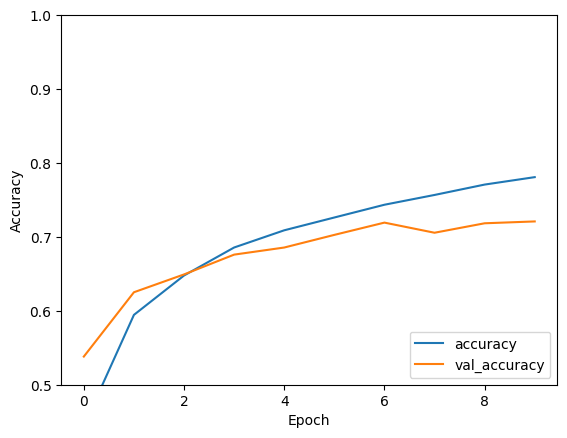

In [10]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [11]:
print(test_acc)

0.7208999991416931


이 간단한 CNN은 70% 이상의 테스트 정확도를 달성했습니다. 몇 줄의 코드로는 나쁘지 않습니다! 다른 CNN 스타일은 Keras 서브클래싱 API 및 `tf.GradientTape`를 사용하는 <a>전문가를 위한 TensorFlow 2 빠른 시작</a> 예제를 확인하세요.